In [ ]:
!python --version

Python 3.7.13


## Import GG Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# OCR (EasyOCR)


## Install OCR Lib

In [ ]:
!pip install editdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!sudo apt install tesseract-ocr-tha
#!sudo apt install tesseract-ocr

#!pip install pytesseract

!pip install -U Pillow


!pip install easyocr



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pythainlp

#!pip install epitran
#!pip install sklearn_crfsuite
#!pip install transformers sentencepiece   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Idnum + name, lastname

In [ ]:
# ID_number and name, lastname Check (ESOCR)
import editdistance
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
#import pytesseract as pts
import requests
import easyocr
from pythainlp.util import isthai


def Get_Idcard_detail(file_path):
  raw_data = []
  id_num = {"id_num" : "None"}
  name = file_path
  img = Image.open(name)
  img = ImageOps.exif_transpose(img) # fix image rotating
  #img = img.convert('L') #Convert to gray
  #img.save(name)

  #pytherass
  ''' text = pts.image_to_string(img, lang='tha+eng')
  raw_data = text.split() ''' 

  #Easy OCR
  # Doing OCR. Get bounding boxes.
  reader = easyocr.Reader(['en'])#['th','en']
  bounds = reader.readtext(name)

  split_data = []
  try:
    for data in bounds:
      split_data.append(data[1])
  except:
      print("--------Oops! index out of range-------") 

  raw_data = split_data  



  def get_english(raw_list): # Cut only english var
    eng_name = []
    thai_name = []

    for name in raw_list:
      if isthai(name) == True:
        thai_name.append(name)
      else:
        eng_name.append(name)

    ''' print("\Engname")
    print(eng_name)
    print()
    print("\Thainame")
    print(thai_name) '''
    return eng_name
  
  raw_data = get_english(raw_data)


  def Clear_syntax(raw_list):

    Clean_syntax = ["","#","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

    for k in range(len(Clean_syntax)):
      while (Clean_syntax[k] in raw_list): # remove single symbol
        raw_list.remove(Clean_syntax[k])

    for l in range(len(raw_list)): 
      raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
      raw_list[l] = raw_list[l].lower() #Set all string to lowercase

    for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
      for n in range(len(Clean_syntax)):
          raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
    return raw_list
  
  raw_data = Clear_syntax(raw_data)
  

  def get_idnum(raw_list):
    id_num = {"id_num" : "None"}
    # 1. normal check 
    for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
      try:
        if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
          id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
          break 
      except:
        pass
    
    # 2. Hardcore Check
    if id_num["id_num"] == "None":
      id_count = 0
      index_first = 0
      index_end = 0
      for i in range(len(raw_list)):
        if id_count == 13:
          index_end = i-1 #ลบ 1 index เพราะ ครบ 13 รอบก่อนหน้านี้
          #print(f"index_first == {index_first} index_end == {index_end}")
          #print(f"id = {raw_list[index_first:index_end+1]}")
          id_num["id_num"] = ''.join(raw_list[index_first:index_end+1]) 
          break
        else:
          if raw_list[i].isnumeric() == True and index_first == 0:
            id_count += len(raw_list[i])
            index_first = i
          elif raw_list[i].isnumeric() == True and index_first != 0:
            id_count += len(raw_list[i])
          elif raw_list[i].isnumeric() == False:
            id_count = 0
            index_first = 0
          
    return id_num

  id_num = (get_idnum(raw_data))

      #Complete list name check
  def list_name_check(raw_list):
    sum_list = raw_list
    name_key = ['name', 'lastname']

    #1. name_key check
    if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
      pass
    else:
      for i in range(len(name_key)):
        for j in range(len(sum_list)):
          if (editdistance.eval(name_key[i], sum_list[j]) <= 2 ): 
            sum_list[j] = name_key[i]
    
    gender_key = ["mr.", "mrs.", 'master', 'miss']
    #2 gender_key check
    count = 0 # check for break
    for i in range(len(gender_key)):
      for j in range(len(sum_list)):
        if (count == 0):
          try:
            if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
              pass
            else:
              # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
              if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
              elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
          except:
            if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
            elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
        else:
          break
    
    return sum_list

  raw_data = list_name_check(raw_data)

  #get_eng_name
  def get_engname(raw_list):
    get_data = raw_list
    engname_list = []

    name_pos = [] 
    lastname_pos = []
    mr_pos = []
    mrs_pos = []

      # check keyword by name, lastname, master, mr, miss, mrs
    for j in range(len(get_data)): #get "name" , "lastname" index
      if "name" == get_data[j]:
        name_pos.append(j)
      elif "lastname" == get_data[j]:
        lastname_pos.append(j)
      elif ("mr." == get_data[j]) or ("master" == get_data[j]):
        mr_pos.append(j)
      elif ("miss" == get_data[j]) or ("mrs." == get_data[j]):
        mrs_pos.append(j)


    if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
      engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
    elif len(lastname_pos) != 0:
      engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
    elif len(mr_pos) != 0:
      engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
    elif len(mrs_pos) != 0:
      engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
    else:
      print("Can't find eng name!!") 

    return engname_list
  
  raw_data = get_engname(raw_data)

  

  
  def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate" -> "jate"
    data = raw_list
    key = ['mrs.','mr.','master','miss']
    name = "" #gen_key name
    name_pos = 0
    gen_index = 0
    gen_type = "" #male / female
    # check keyword
    for key_val in key:
        for each_text in data:
            if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
                #each_text = each_text[len(key):]
                if (each_text == "name") or (each_text == "lastname"):
                  pass
                else:
                  name = (each_text[:len(key_val)])
                  name_pos = data.index(each_text) # get_index
                  gen_index = len(key_val)
                  """ if (key_val == key[0]) or (key_val == key[1]):
                      gen_type = "male"
                  else:
                      gen_type = "female"  """
                  break
    if (name_pos != 0): 
      data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
      for empty_str in range(data.count('')): # clear "empty string"
        data.remove('')
    return data
  
  raw_data = split_genkey(raw_data)
  
  
  def clean_name_data(raw_list): # delete all single string and int string
    for k in range(len(raw_list)):
      try:
        while ((len(raw_list[k]) <= 2) or (raw_list[k].isnumeric() == True)): # remove single symbol
          raw_list.remove(raw_list[k])
      except IndexError:
        pass
    return raw_list
  
  raw_data = clean_name_data(raw_data)


  def name_sum(raw_list):
    info = {"name" : "None",
            "lastname" : "None"}
    key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
    name_pos = 0
    lastname_pos = 0
    for key_val in key: # remove gender_key in string
      if key_val in raw_list:
        raw_list.remove(key_val)
    try:
      for i in range(len(raw_list)):
        if raw_list[i] == "name":
          info["name"] = raw_list[i+1]
          name_pos = i+1
        elif raw_list[i] == "lastname":
          info["lastname"] = raw_list[i+1]
          lastname_pos = i+1
    except:
      pass
    
    # กรณี หาอย่างใดอย่าหนึ่งเจอให้ลองข้ามไปดู 1 index name, "name_val", lastname , "lastname_val"
    if (info["name"] != "None") and (info["lastname"] == "None"):
      try:
        info["lastname"] = raw_list[name_pos+2]
      except:
        pass
    elif (info["lastname"] != "None") and (info["name"] == "None"):
      try:
        info["name"] = raw_list[lastname_pos-2]
      except:
        pass
    
    # remove . on "mr." and "mrs."
    info["name"] = info["name"].replace(".","")
    info["lastname"] = info["lastname"].replace(".","")

    
    return info

  print("Process Completed!.....")
  print(id_num)
  print(name_sum(raw_data))






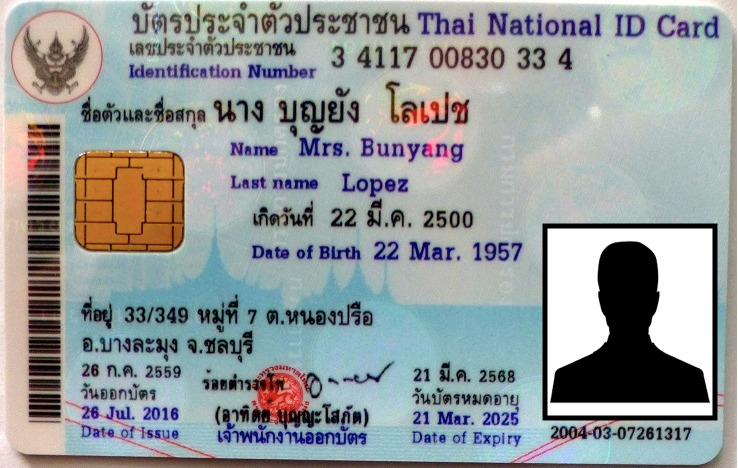

In [ ]:
from PIL import Image
#Test image 
img = Image.open("/content/idcard_ex.jpg")
img = ImageOps.exif_transpose(img) # fix image rotating
img

In [ ]:
import time
t1 = time.perf_counter()


Get_Idcard_detail(file_path="/content/18.test_set(Neg).jpeg")

t2 = time.perf_counter()
print('time taken to run: {:.2f} sec'.format(t2-t1))



## Id_num 


In [ ]:
# ID_number Check (ESOCR)
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import pytesseract as pts
import requests
import easyocr
from pythainlp.util import isthai


def Get_Idcard_num(file_path):
  raw_data = []
  name = file_path
  img = Image.open(name)
  img = ImageOps.exif_transpose(img) # fix image rotating
  img = img.convert('L') #Convert to gray
  img.save(name)

  #pytherass
  ''' text = pts.image_to_string(img, lang='tha+eng')
  raw_data = text.split() ''' 

  #Easy OCR
  # Doing OCR. Get bounding boxes.
  reader = easyocr.Reader(['en'])#['th','en']
  bounds = reader.readtext(name)

  split_data = []
  try:
    for data in bounds:
      split_data.append(data[1])
  except:
      print("--------Oops! index out of range-------") 

  raw_data = split_data  



  def get_english(raw_list): # Cut only english var
    eng_name = []
    thai_name = []

    for name in raw_list:
      if isthai(name) == True:
        thai_name.append(name)
      else:
        eng_name.append(name)

    ''' print("\Engname")
    print(eng_name)
    print()
    print("\Thainame")
    print(thai_name) '''
    return eng_name
  
  raw_data = get_english(raw_data)

      

  

  def Clear_syntax(raw_list):

    Clean_syntax = ["","#",".","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘"]

    for k in range(len(Clean_syntax)):
      while (Clean_syntax[k] in raw_list): # remove single symbol
        raw_list.remove(Clean_syntax[k])

    for l in range(len(raw_list)): 
      raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
      raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].lower() #Set all string to lowercase

    for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
      for n in range(len(Clean_syntax)):
        if Clean_syntax[n] != ".":
          raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") #split ! --> l (Error OCR Check)
    return raw_list
  
  raw_data = Clear_syntax(raw_data)
  

  def get_idnum(raw_list):
    id_num = {"id_num" : "None"}
    # 1. normal check 
    for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
      try:
        if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
          id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
          break 
      except:
        pass
    
    # 2. Hardcore Check
    if id_num["id_num"] == "None":
      id_count = 0
      index_first = 0
      index_end = 0
      for i in range(len(raw_list)):
        if id_count == 13:
          index_end = i-1 #ลบ 1 index เพราะ ครบ 13 รอบก่อนหน้านี้
          #print(f"index_first == {index_first} index_end == {index_end}")
          #print(f"id = {raw_list[index_first:index_end+1]}")
          id_num["id_num"] = ''.join(raw_list[index_first:index_end+1]) 
          break
        else:
          if raw_list[i].isnumeric() == True and index_first == 0:
            id_count += len(raw_list[i])
            index_first = i
          elif raw_list[i].isnumeric() == True and index_first != 0:
            id_count += len(raw_list[i])
          elif raw_list[i].isnumeric() == False:
            id_count = 0
            index_first = 0
          
    return id_num

  print("Process Completed!.....")
  print(get_idnum(raw_data))


Get_Idcard_num(file_path="/content/drive/MyDrive/AI Builder/Dataset/old data/IDCard/26.jpg")

In [ ]:
Get_Idcard_detail(file_path="/content/drive/MyDrive/AI Builder/Dataset/old data/IDCard/26.jpg")

In [ ]:
# Eng_name check (ESOCR)
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import pytesseract as pts
import requests
import easyocr
import editdistance
from pythainlp.util import isthai

def Get_Eng_name(file_path):
  raw_data = []
  name = file_path
  img = Image.open(name)
  img = ImageOps.exif_transpose(img)
  img = img.convert('L') #Convert to gray
  img.save(name)

  #pytherass
  ''' text = pts.image_to_string(img, lang='eng')
  raw_data = text.split() '''   

  #Easy OCR
  # Doing OCR. Get bounding boxes.
  reader = easyocr.Reader(['en'])#['th','en']
  bounds = reader.readtext(name)

  split_data = []
  try:
    for data in bounds:
      split_data.append(data[1])
  except:
      print("--------Oops! index out of range-------") 

  raw_data = split_data  

  def get_english(raw_list): # Cut only english var
    eng_name = []
    thai_name = []

    for name in raw_list:
      if isthai(name) == True:
        thai_name.append(name)
      else:
        eng_name.append(name)

    ''' print("\Engname")
    print(eng_name)
    print()
    print("\Thainame")
    print(thai_name) '''
    return eng_name
  
  raw_data = get_english(raw_data)

  def Clear_syntax(raw_list):

    Clean_syntax = ["","#",".","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

    for k in range(len(Clean_syntax)):
      while (Clean_syntax[k] in raw_list): # remove single symbol
        raw_list.remove(Clean_syntax[k])

    for l in range(len(raw_list)): 
      raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
      raw_list[l] = raw_list[l].lower() #Set all string to lowercase

    for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
      for n in range(len(Clean_syntax)):
          raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
    return raw_list
  
  raw_data = Clear_syntax(raw_data)

  #Complete list name check
  def list_name_check(raw_list):
    sum_list = raw_list
    name_key = ['name', 'lastname']

    #1. name_key check
    if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
      pass
    else:
      for i in range(len(name_key)):
        for j in range(len(sum_list)):
          if (editdistance.eval(name_key[i], sum_list[j]) <= 2 ): 
            sum_list[j] = name_key[i]
    
    gender_key = ["mr", "mrs", 'master', 'miss']
    #2 gender_key check
    count = 0 # check for break
    for i in range(len(gender_key)):
      for j in range(len(sum_list)):
        if (count == 0):
          try:
            if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
              pass
            else:
              # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
              if (gender_key[i] == "mr" or gender_key[i] == "mrs") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
              elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
          except:
            if (gender_key[i] == "mr" or gender_key[i] == "mrs") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
            elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
        else:
          break
    
    return sum_list

  raw_data = list_name_check(raw_data)

  #get_eng_name
  def get_engname(raw_list):
    get_data = raw_list
    engname_list = []

    name_pos = [] 
    lastname_pos = []
    mr_pos = []
    mrs_pos = []

      # check keyword by name, lastname, master, mr, miss, mrs
    for j in range(len(get_data)): #get "name" , "lastname" index
      if "name" == get_data[j]:
        name_pos.append(j)
      elif "lastname" == get_data[j]:
        lastname_pos.append(j)
      elif ("mr" == get_data[j]) or ("master" == get_data[j]):
        mr_pos.append(j)
      elif ("miss" == get_data[j]) or ("mrs" == get_data[j]):
        mrs_pos.append(j)


    if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
      engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
    elif len(lastname_pos) != 0:
      engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
    elif len(mr_pos) != 0:
      engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
    elif len(mrs_pos) != 0:
      engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
    else:
      print("Can't find eng name!!") 

    return engname_list
  
  raw_data = get_engname(raw_data)

  

  
  def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate"
    data = raw_list
    key = ['mrs','mr','master','miss']
    name = "" #gen_key name
    name_pos = 0
    gen_index = 0
    gen_type = "" #male / female
    # check keyword
    for key_val in key:
        for each_text in data:
            if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
                #each_text = each_text[len(key):]
                if (each_text == "name") or (each_text == "lastname"):
                  pass
                else:
                  name = (each_text[:len(key_val)])
                  name_pos = data.index(each_text) # get_index
                  gen_index = len(key_val)
                  """ if (key_val == key[0]) or (key_val == key[1]):
                      gen_type = "male"
                  else:
                      gen_type = "female"  """
                  break
    if (name_pos != 0): 
      data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
      for empty_str in range(data.count('')): # clear "empty string"
        data.remove('')
    return data
  
  raw_data = split_genkey(raw_data)
  
  
  def clean_name_data(raw_list): # delete all single string and int string
    for k in range(len(raw_list)):
      try:
        while ((len(raw_list[k]) <= 2) or (raw_list[k].isnumeric() == True)): # remove single symbol
          raw_list.remove(raw_list[k])
      except IndexError:
        pass
    return raw_list
  
  raw_data = clean_name_data(raw_data)


  def name_sum(raw_list):
    info = {"name" : "None",
            "lastname" : "None"}
    key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
    name_pos = 0
    lastname_pos = 0
    for key_val in key: # remove gender_key in string
      if key_val in raw_list:
        raw_list.remove(key_val)
    try:
      for i in range(len(raw_list)):
        if raw_list[i] == "name":
          info["name"] = raw_list[i+1]
          name_pos = i+1
        elif raw_list[i] == "lastname":
          info["lastname"] = raw_list[i+1]
          lastname_pos = i+1
    except:
      pass
    
    # กรณี หาอย่างใดอย่าหนึ่งเจอให้ลองข้ามไปดู
    if (info["name"] != "None") and (info["lastname"] == "None"):
      try:
        info["lastname"] = raw_list[name_pos+2]
      except:
        pass
    elif (info["lastname"] != "None") and (info["name"] == "None"):
      try:
        info["name"] = raw_list[lastname_pos-2]
      except:
        pass
    
    return info

  print("Process Completed!.....")
  print(name_sum(raw_data))


Get_Eng_name(file_path="/content/drive/MyDrive/AI Builder/Dataset/old data/IDCard/26.jpg")

## OCR Lecture

In [ ]:
name = '/content/drive/MyDrive/Dataset/ATK+ID/2473C41B-C9B5-4EB5-A0BD-C942CEDFD94F - 5315 เพชรแพรทอง อินอุทัย.jpeg'


In [ ]:
name = "/content/IMG20220326171604 - 5340 ธนอนันท์.jpg"

In [ ]:
!git clone https://github.com/xuebinqin/U-2-Net.git
!pip install coremltools


Cloning into 'U-2-Net'...
remote: Enumerating objects: 1017, done.
remote: Counting objects: 100% (413/413), done.
remote: Compressing objects: 100% (281/281), done.
remote: Total 1017 (delta 231), reused 226 (delta 130), pack-reused 604
Receiving objects: 100% (1017/1017), 48.08 MiB | 38.10 MiB/s, done.
Resolving deltas: 100% (477/477), done.
     |████████████████████████████████| 1.6 MB 5.4 MB/s 


In [ ]:
#Change name
filename_type = [".jpg",".png",".jpeg"]

def change_name(file_name, change_keyword):
  name = file_name
  file_type = ""
  file_name = ""
  new_file = ""

  if name[-5] == ".":
    file_type = name[-5:]
    file_name = name[:-5]
  elif name[-4] == ".":
    file_type = name[-4:]
    file_name = name[:-4]

  new_file = file_name + "_" + change_keyword + file_type
  return new_file

change_name("/content/drive/Test/AI Builder/Dataset/ATK_data/IMG_4010.JPG", "crop")


'/content/drive/Test/AI Builder/Dataset/ATK_data/IMG_4010_crop.JPG'

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL

angle = 180
img = Image.open(name)
img = ImageOps.exif_transpose(img) # fix image rotating
img = img.convert('L') #Convert to gray

#img = img.rotate(angle)
img.save(name)

display(img) 


In [ ]:
import easyocr
#Easy OCR
# Doing OCR. Get bounding boxes.
reader = easyocr.Reader(['en', 'th'])#['th','en']
bounds = reader.readtext(name)

split_data = []
try:
  for data in bounds:
    split_data.append(data[1])
except:
    print("--------Oops! index out of range-------") 

data = split_data
data

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

['od',
 ';ุ',
 'a ๑',
 'รุง;ู',
 'รูะู',
 'ู',
 'd',
 'รู้',
 '9.',
 'ฮี',
 'รุ',
 'อู',
 'อี้',
 '>ู]',
 'รุรู้',
 'รู้',
 'e',
 'รุ้',
 ')',
 'ม',
 ' รู้',
 'eั',
 'กูร',
 'ธี้',
 'รกจุ',
 '"นู',
 '',
 '.',
 'กุ',
 'รู้',
 '&',
 'รุ๊',
 'e',
 'อีู้',
 'รุ',
 'รอี๋',
 'e',
 'ธิ๋',
 's',
 'รรู๊',
 'งู',
 'รุ๊',
 'ตุ๋',
 'e.',
 'lp8',
 'ธุ๋',
 '๑',
 'งู',
 'อู',
 'รู้',
 'รู*ู',
 '๓',
 '=ู',
 'จุ้',
 'e',
 'รู้',
 'ii',
 'รุ๊:',
 'รุู',
 '%.',
 'รู้',
 'f',
 'รู้',
 'รู้',
 'ธุ๋',
 'e',
 '๘',
 'รู้',
 'รี',
 'รี',
 'ร',
 'aa',
 'ธุ๋',
 's',
 'ฮี',
 'รุ',
 '=ู',
 'g',
 'a',
 'ตา',
 'กู',
 'ะู',
 'อู้',
 'a',
 ':ู',
 '$']

In [ ]:
import pytesseract as pts
 #pytherass
text = pts.image_to_string(img, lang='tha+eng')
data = text.split()
print("\\Pytesseract len == " + str(len(data)))
print(data)


\Pytesseract len == 2
['ด', 'ฏ']


In [ ]:
import cv2
from pytesseract import Output
from google.colab.patches import cv2_imshow

img = cv2.imread(name)
height = img.shape[0]
width = img.shape[1]

d = pts.image_to_boxes(img, output_type=Output.DICT)
n_boxes = len(d['char'])
for i in range(n_boxes):
    (text,x1,y2,x2,y1) = (d['char'][i],d['left'][i],d['top'][i],d['right'][i],d['bottom'][i])
    cv2.rectangle(img, (x1,height-y1), (x2,height-y2) , (0,255,0), 2)
cv2_imshow(img)
#cv2_waitKey(0) 

In [ ]:
def Clear_syntax(raw_list):

  Clean_syntax = ["","#",".","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘", "ๆ"]

  for k in range(len(Clean_syntax)):
    while (Clean_syntax[k] in raw_list): # remove single symbol
      raw_list.remove(Clean_syntax[k])

  for l in range(len(raw_list)): 
    raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
    raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
    raw_list[l] = raw_list[l].lower() #Set all string to lowercase

  for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
    for n in range(len(Clean_syntax)):
      #raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") # remove all symbol
       if Clean_syntax[n] != ".":
        raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") # remove all symbol 
  
      
  return raw_list

split_data = Clear_syntax(data)

#Cleaning data 
print("Cleaning Data len == " + str(len(split_data)))
data = split_data
data

In [ ]:
def get_idnum(raw_list):
  id_num = {"id_num" : "None"}
  # 1. normal check 
  for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
    if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
      id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
      break 
  
  # 2. Hardcore Check
  if id_num["id_num"] == "None":
    id_count = 0
    index_first = 0
    index_end = 0
    for i in range(len(raw_list)):
      if id_count == 13:
        index_end = i
        #print(f"index_first == {index_first} index_end == {index_end}")
        #print(f"id = {raw_list[index_first:index_end+1]}")
        id_num["id_num"] = ''.join(raw_list[index_first:index_end]) 
        break
      else:
        if raw_list[i].isnumeric() == True and index_first == 0:
          id_count += len(raw_list[i])
          index_first = i
        elif raw_list[i].isnumeric() == True and index_first != 0:
          id_count += len(raw_list[i])
        elif raw_list[i].isnumeric() == False:
          id_count = 0
          index_first = 0
        

    
  return id_num
  
get_idnum(data)

In [ ]:
from pythainlp.util import isthai

def get_english(raw_list):
  eng_name = []
  thai_name = []

  for name in raw_list:
    if isthai(name) == True:
      thai_name.append(name)
    else:
      eng_name.append(name)

  print("\Engname")
  print(eng_name)
  print()
  print("\Thainame")
  print(thai_name) 


get_english(data)
  




In [ ]:
#get_eng_name
def get_engname(raw_list):
  get_data = raw_list
  engname_list = []

  name_pos = [] 
  lastname_pos = []
  mr_pos = []
  mrs_pos = []

    # check keyword by name, lastname, master, mr, miss, mrs
  for j in range(len(get_data)): #get "name" , "lastname" index
    if "name" == get_data[j]:
      name_pos.append(j)
    elif "lastname" == get_data[j]:
      lastname_pos.append(j)
    elif ("mr" == get_data[j]) or ("master" == get_data[j]):
      mr_pos.append(j)
    elif ("miss" == get_data[j]) or ("mrs" == get_data[j]):
      mrs_pos.append(j)


  if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
    engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
  elif len(lastname_pos) != 0:
    engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
  elif len(mr_pos) != 0:
    engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
  elif len(mrs_pos) != 0:
    engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
  else:
    engname_list = raw_list 

  return engname_list

print("\engname Classifi")
get_engname(data)
#get_engname(['name', 'mr.sarankorn', 'lastname', 'chaisuntranon', '160', '16u'])




## Loop Check Accuracy and Detail (OCR Idcard) OwO

### **id_num check**

In [ ]:
# ID_number Check (ESOCR)
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import pytesseract as pts
import requests
import easyocr
from pythainlp.util import isthai


def Get_Idcard_num(file_path, save_path):
for filename in os.listdir(file_path):
    img = Image.open(name)
    img = ImageOps.exif_transpose(img) # fix image rotating
    img = img.convert('L') #Convert to gray
    img.save(name)

    #pytherass
    ''' text = pts.image_to_string(img, lang='tha+eng')
    raw_data = text.split() ''' 

    #Easy OCR
    # Doing OCR. Get bounding boxes.
    reader = easyocr.Reader(['en'])#['th','en']
    bounds = reader.readtext(name)

    split_data = []
    try:
      for data in bounds:
        split_data.append(data[1])
    except:
        print("--------Oops! index out of range-------") 

    raw_data = split_data  



    def get_english(raw_list): # Cut only english var
      eng_name = []
      thai_name = []

      for name in raw_list:
        if isthai(name) == True:
          thai_name.append(name)
        else:
          eng_name.append(name)

      ''' print("\Engname")
      print(eng_name)
      print()
      print("\Thainame")
      print(thai_name) '''
      return eng_name
    
    raw_data = get_english(raw_data)

        

    

    def Clear_syntax(raw_list):

      Clean_syntax = ["","#",".","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘"]

      for k in range(len(Clean_syntax)):
        while (Clean_syntax[k] in raw_list): # remove single symbol
          raw_list.remove(Clean_syntax[k])

      for l in range(len(raw_list)): 
        raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
        raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].lower() #Set all string to lowercase

      for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
        for n in range(len(Clean_syntax)):
          if Clean_syntax[n] != ".":
            raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") #split ! --> l (Error OCR Check)
      return raw_list
    
    raw_data = Clear_syntax(raw_data)
    

    def get_idnum(raw_list):
      id_num = {"id_num" : "None"}
      # 1. normal check 
      for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
        try:
          if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
            id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
            break 
        except:
          pass
      
      # 2. Hardcore Check
      if id_num["id_num"] == "None":
        id_count = 0
        index_first = 0
        index_end = 0
        for i in range(len(raw_list)):
          if id_count == 13:
            index_end = i-1 #ลบ 1 index เพราะ ครบ 13 รอบก่อนหน้านี้
            #print(f"index_first == {index_first} index_end == {index_end}")
            #print(f"id = {raw_list[index_first:index_end+1]}")
            id_num["id_num"] = ''.join(raw_list[index_first:index_end+1]) 
            break
          else:
            if raw_list[i].isnumeric() == True and index_first == 0:
              id_count += len(raw_list[i])
              index_first = i
            elif raw_list[i].isnumeric() == True and index_first != 0:
              id_count += len(raw_list[i])
            elif raw_list[i].isnumeric() == False:
              id_count = 0
              index_first = 0
            
      return id_num
  



    def Save_totext(file_name, write_text):
      f = open(file_name, "a" )
      f.write(str(filename) + " == " + str(write_text) + "\n" + "\n")
      f.close()
    
    Save_totext(save_path + "/" + "Id_num_Conclude!.txt", get_idnum(raw_data)) #Set file name to save
  print("Process Completed!.....")


Get_Idcard_num("/content/drive/MyDrive/AI Builder/Dataset/old data/IDCard", "/content")

Status.. == 15.jpg
Status.. == 12.jpeg
Status.. == 14.jpg
Status.. == 29.jpg
Status.. == 10.jpeg
Status.. == 28.jpg


KeyboardInterrupt: ignored

### **Name, Lastname OCR check**

In [ ]:
# Eng_name check (ESOCR)
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import pytesseract as pts
import requests
import easyocr
import editdistance
from pythainlp.util import isthai

def Get_Eng_name(file_path, save_path):
  for filename in os.listdir(file_path):
    print("Status.. == " + filename)
    raw_data = []
    name = file_path + "/" + filename
    img = Image.open(name)
    img = ImageOps.exif_transpose(img)
    img = img.convert('L') #Convert to gray
    img.save(name)

    #pytherass
    ''' text = pts.image_to_string(img, lang='eng')
    raw_data = text.split() '''   

    #Easy OCR
    # Doing OCR. Get bounding boxes.
    reader = easyocr.Reader(['en'])#['th','en']
    bounds = reader.readtext(name)

    split_data = []
    try:
      for data in bounds:
        split_data.append(data[1])
    except:
        print("--------Oops! index out of range-------") 

    raw_data = split_data  

    def get_english(raw_list): # Cut only english var
      eng_name = []
      thai_name = []

      for name in raw_list:
        if isthai(name) == True:
          thai_name.append(name)
        else:
          eng_name.append(name)

      ''' print("\Engname")
      print(eng_name)
      print()
      print("\Thainame")
      print(thai_name) '''
      return eng_name
    
    raw_data = get_english(raw_data)

    def Clear_syntax(raw_list):

      Clean_syntax = ["","#","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

      for k in range(len(Clean_syntax)):
        while (Clean_syntax[k] in raw_list): # remove single symbol
          raw_list.remove(Clean_syntax[k])

      for l in range(len(raw_list)): 
        raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
        raw_list[l] = raw_list[l].lower() #Set all string to lowercase

      for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
        for n in range(len(Clean_syntax)):
            raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
      return raw_list
    
    raw_data = Clear_syntax(raw_data)

    #Complete list name check
    def list_name_check(raw_list):
      sum_list = raw_list
      name_key = ['name', 'lastname']

      #1. name_key check
      if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
        pass
      else:
        for i in range(len(name_key)):
          for j in range(len(sum_list)):
            if (editdistance.eval(name_key[i], sum_list[j]) <= 2 ): 
              sum_list[j] = name_key[i]
      
      gender_key = ["mr.", "mrs.", 'master', 'miss']
      #2 gender_key check
      count = 0 # check for break
      for i in range(len(gender_key)):
        for j in range(len(sum_list)):
          if (count == 0):
            try:
              if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
                pass
              else:
                # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
                if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
                elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
            except:
              if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
              elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
          else:
            break
      
      return sum_list

    raw_data = list_name_check(raw_data)

    #get_eng_name
    def get_engname(raw_list):
      get_data = raw_list
      engname_list = []

      name_pos = [] 
      lastname_pos = []
      mr_pos = []
      mrs_pos = []

        # check keyword by name, lastname, master, mr, miss, mrs
      for j in range(len(get_data)): #get "name" , "lastname" index
        if "name" == get_data[j]:
          name_pos.append(j)
        elif "lastname" == get_data[j]:
          lastname_pos.append(j)
        elif ("mr." == get_data[j]) or ("master" == get_data[j]):
          mr_pos.append(j)
        elif ("miss" == get_data[j]) or ("mrs." == get_data[j]):
          mrs_pos.append(j)


      if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
        engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
      elif len(lastname_pos) != 0:
        engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
      elif len(mr_pos) != 0:
        engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
      elif len(mrs_pos) != 0:
        engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
      else:
        print("Can't find eng name!!") 

      return engname_list
    
    raw_data = get_engname(raw_data)

    

    
    def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate"
      data = raw_list
      key = ['mrs.','mr.','master','miss']
      name = "" #gen_key name
      name_pos = 0
      gen_index = 0
      gen_type = "" #male / female
      # check keyword
      for key_val in key:
          for each_text in data:
              if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
                  #each_text = each_text[len(key):]
                  if (each_text == "name") or (each_text == "lastname"):
                    pass
                  else:
                    name = (each_text[:len(key_val)])
                    name_pos = data.index(each_text) # get_index
                    gen_index = len(key_val)
                    """ if (key_val == key[0]) or (key_val == key[1]):
                        gen_type = "male"
                    else:
                        gen_type = "female"  """
                    break
      if (name_pos != 0): 
        data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
        for empty_str in range(data.count('')): # clear "empty string"
          data.remove('')
      return data
    
    raw_data = split_genkey(raw_data)
    
    
    def clean_name_data(raw_list): # delete all single string and int string
      for k in range(len(raw_list)):
        try:
          while ((len(raw_list[k]) <= 2) or (raw_list[k].isnumeric() == True)): # remove single symbol
            raw_list.remove(raw_list[k])
        except IndexError:
          pass
      return raw_list
    
    raw_data = clean_name_data(raw_data)


    def name_sum(raw_list):
      info = {"name" : "None",
              "lastname" : "None"}
      key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
      name_pos = 0
      lastname_pos = 0
      for key_val in key: # remove gender_key in string
        if key_val in raw_list:
          raw_list.remove(key_val)
      try:
        for i in range(len(raw_list)):
          if raw_list[i] == "name":
            info["name"] = raw_list[i+1]
            name_pos = i+1
          elif raw_list[i] == "lastname":
            info["lastname"] = raw_list[i+1]
            lastname_pos = i+1
      except:
        pass
      
      # กรณี หาอย่างใดอย่าหนึ่งเจอให้ลองข้ามไปดู
      if (info["name"] != "None") and (info["lastname"] == "None"):
        try:
          info["lastname"] = raw_list[name_pos+2]
        except:
          pass
      elif (info["lastname"] != "None") and (info["name"] == "None"):
        try:
          info["name"] = raw_list[lastname_pos-2]
        except:
          pass
      
      # remove . on "mr." and "mrs."
      info["name"] = info["name"].replace(".","")
      info["lastname"] = info["lastname"].replace(".","")
      return info

    print(name_sum(raw_data))


    def Save_totext(file_name, write_text):
      f = open(file_name, "a" )
      f.write(str(filename) + " == " + str(write_text) + "\n" + "\n")
      f.close() 
    
    Save_totext( save_path + "/" + "Eng_name_conclude_debug!.txt", name_sum(raw_data)) #Set file name to save
  print("Process Completed!.....")


Get_Eng_name("/content/drive/MyDrive/AI Builder/Dataset/Dataset/ATK+Idcard","/content/drive/MyDrive/AI Builder/Dataset/Data_result/Idcard_Data(last debug!)")



### Easy OCR bounding box check




In [ ]:
# ID Gray Box Crop (Easy OCR)
from torch.functional import split
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import easyocr
import numpy as np



#Get Eng name dataset
for filename in os.listdir("/content/drive/MyDrive/AI Builder/Dataset/IDCard"):
  raw_data = []
  name = "/content/drive/MyDrive/AI Builder/Dataset/IDCard" + "/" + filename
  img = Image.open(name)
  img = ImageOps.exif_transpose(img) # fix image rotating
  img = img.convert('L') #Convert to gray
  img.save(name)


  reader = easyocr.Reader(['th','en'])
  bounds = reader.readtext(name)

  split_data = []
  try:
    for data in bounds:
      split_data.append(data[1])
  except:
      print("--------Oops! index out of range-------") 

  #Easy OCR Crop Pic
  # Draw bounding boxes
  def draw_boxes(image, bounds, color='green', width=6):
      draw = ImageDraw.Draw(image)
      for bound in bounds:
          p0, p1, p2, p3 = bound[0]
          draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
      return image

  draw_boxes(img, bounds).save("/content/drive/MyDrive/AI Builder/Dataset/ID_EOCR_gray/" + filename)

###**Raw_list idcard check**

In [ ]:
# Raw_data(PTS)
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import pytesseract as pts
import requests
from pythainlp.util import isthai
import easyocr



def Get_raw_data(file_path, save_path):
  for filename in os.listdir(file_path):
    print("Status.. == " + filename)
    raw_data = []
    name = file_path + "/" + filename
    img = Image.open(name)
    img = ImageOps.exif_transpose(img)
    img = img.convert('L') #Convert to gray

    reader = easyocr.Reader(['en'])
    bounds = reader.readtext(name)

    #EasyOCR
    split_data = []
    try:
      for data in bounds:
        split_data.append(data[1])
    except:
        print("--------Oops! index out of range-------") 
    raw_data = split_data

    ''' #pytherass
    text = pts.image_to_string(img, lang='tha+eng')
    raw_data = text.split()  '''

    def get_english(raw_list): # Cut only english var
      eng_name = []
      thai_name = []

      for name in raw_list:
        if isthai(name) == True:
          thai_name.append(name)
        else:
          eng_name.append(name)

      ''' print("\Engname")
      print(eng_name)
      print()
      print("\Thainame")
      print(thai_name) '''
      return eng_name
    
    raw_data = get_english(raw_data)


    def Clear_syntax(raw_list):

      Clean_syntax = ["","#",".","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

      for k in range(len(Clean_syntax)):
        while (Clean_syntax[k] in raw_list): # remove single symbol
          raw_list.remove(Clean_syntax[k])

      for l in range(len(raw_list)): 
        raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
        raw_list[l] = raw_list[l].lower() #Set all string to lowercase

      for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
        for n in range(len(Clean_syntax)):
            raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
      return raw_list
    
    raw_data = Clear_syntax(raw_data)




    def Save_totext(file_name, write_text):
      f = open(file_name, "a" )
      f.write(str(filename) + " == " + str(write_text) + "\n" + "\n")
      f.close()
    
    Save_totext(save_path + "/" + "Raw_data(ESOCR)_conclude!.txt", raw_data) #Set file name to save
  print("Process Completed!.....")


Get_raw_data("/content/drive/MyDrive/AI Builder/Dataset/Dataset/ATK+Idcard","/content/drive/MyDrive/AI Builder/Dataset/Data_result/Idcard_Data(last debug!)")

### Put all thing together (id_num + name ; lastname)

In [ ]:
# ID_number and name, lastname Check (ESOCR)
import editdistance
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
import pytesseract as pts
import requests
import easyocr
from pythainlp.util import isthai
import pandas as pd

#save name not need to add .csv
def Get_Idcard_detail(file_path, save_path, save_name):
  print("running ...")
  Data = {'Name' : [],
              'Lastname' : [],
              'Id_num' : [],
              'file_name' : []}
  count = 0
  for filename in os.listdir(file_path):
    id_num = {"id_num" : "None"}
    #print("Status.. == " + filename)
    name = file_path + "/" + filename
    raw_data = []
    img = Image.open(name)
    img = ImageOps.exif_transpose(img) # fix image rotating
    img = img.convert('L') #Convert to gray
    #img.save(name)
    

    #pytherass
    ''' text = pts.image_to_string(img, lang='tha+eng')
    raw_data = text.split() ''' 

    #Easy OCR
    # Doing OCR. Get bounding boxes.
    reader = easyocr.Reader(['en'])#['th','en']
    bounds = reader.readtext(name)

    split_data = []
    try:
      for data in bounds:
        split_data.append(data[1])
    except:
        print("--------Oops! index out of range-------") 

    raw_data = split_data  



    def get_english(raw_list): # Cut only english var
      eng_name = []
      thai_name = []

      for name in raw_list:
        if isthai(name) == True:
          thai_name.append(name)
        else:
          eng_name.append(name)

      ''' print("\Engname")
      print(eng_name)
      print()
      print("\Thainame")
      print(thai_name) '''
      return eng_name
    
    raw_data = get_english(raw_data)


    def Clear_syntax(raw_list):

      Clean_syntax = ["","#",".","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

      for k in range(len(Clean_syntax)):
        while (Clean_syntax[k] in raw_list): # remove single symbol
          raw_list.remove(Clean_syntax[k])

      for l in range(len(raw_list)): 
        raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
        raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
        raw_list[l] = raw_list[l].lower() #Set all string to lowercase

      for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
        for n in range(len(Clean_syntax)):
            raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
      return raw_list
    
    raw_data = Clear_syntax(raw_data)
    

    def get_idnum(raw_list):
      id_num = {"id_num" : "None"}
      # 1. normal check 
      for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
        try:
          if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
            id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
            break 
        except:
          pass
      
      # 2. Hardcore Check
      if id_num["id_num"] == "None":
        id_count = 0
        index_first = 0
        index_end = 0
        for i in range(len(raw_list)):
          if id_count == 13:
            index_end = i-1 #ลบ 1 index เพราะ ครบ 13 รอบก่อนหน้านี้
            #print(f"index_first == {index_first} index_end == {index_end}")
            #print(f"id = {raw_list[index_first:index_end+1]}")
            id_num["id_num"] = ''.join(raw_list[index_first:index_end+1]) 
            break
          else:
            if raw_list[i].isnumeric() == True and index_first == 0:
              id_count += len(raw_list[i])
              index_first = i
            elif raw_list[i].isnumeric() == True and index_first != 0:
              id_count += len(raw_list[i])
            elif raw_list[i].isnumeric() == False:
              id_count = 0
              index_first = 0
            
      return id_num

    id_num = (get_idnum(raw_data))

        #Complete list name check
    def list_name_check(raw_list):
      sum_list = raw_list
      name_key = ['name', 'lastname']

      #1. name_key check
      if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
        pass
      else:
        for i in range(len(name_key)):
          for j in range(len(sum_list)):
            if (editdistance.eval(name_key[i], sum_list[j]) <= 2 ): 
              sum_list[j] = name_key[i]
      
      gender_key = ["mr", "mrs", 'master', 'miss']
      #2 gender_key check
      count = 0 # check for break
      for i in range(len(gender_key)):
        for j in range(len(sum_list)):
          if (count == 0):
            try:
              if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
                pass
              else:
                # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
                if (gender_key[i] == "mr" or gender_key[i] == "mrs") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
                elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
            except:
              if (gender_key[i] == "mr" or gender_key[i] == "mrs") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
              elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                  sum_list[j] = gender_key[i]
                  count+=1
                  #print(1)
          else:
            break
      
      return sum_list

    raw_data = list_name_check(raw_data)

    #get_eng_name
    def get_engname(raw_list):
      get_data = raw_list
      engname_list = []

      name_pos = [] 
      lastname_pos = []
      mr_pos = []
      mrs_pos = []

        # check keyword by name, lastname, master, mr, miss, mrs
      for j in range(len(get_data)): #get "name" , "lastname" index
        if "name" == get_data[j]:
          name_pos.append(j)
        elif "lastname" == get_data[j]:
          lastname_pos.append(j)
        elif ("mr" == get_data[j]) or ("master" == get_data[j]):
          mr_pos.append(j)
        elif ("miss" == get_data[j]) or ("mrs" == get_data[j]):
          mrs_pos.append(j)


      if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
        engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
      elif len(lastname_pos) != 0:
        engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
      elif len(mr_pos) != 0:
        engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
      elif len(mrs_pos) != 0:
        engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
      else:
        print("Can't find eng name!!") 

      return engname_list
    
    raw_data = get_engname(raw_data)

    

    
    def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate" -> "jate"
      data = raw_list
      key = ['mrs','mr','master','miss']
      name = "" #gen_key name
      name_pos = 0
      gen_index = 0
      gen_type = "" #male / female
      # check keyword
      for key_val in key:
          for each_text in data:
              if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
                  #each_text = each_text[len(key):]
                  if (each_text == "name") or (each_text == "lastname"):
                    pass
                  else:
                    name = (each_text[:len(key_val)])
                    name_pos = data.index(each_text) # get_index
                    gen_index = len(key_val)
                    """ if (key_val == key[0]) or (key_val == key[1]):
                        gen_type = "male"
                    else:
                        gen_type = "female"  """
                    break
      if (name_pos != 0): 
        data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
        for empty_str in range(data.count('')): # clear "empty string"
          data.remove('')
      return data
    
    raw_data = split_genkey(raw_data)
    
    
    def clean_name_data(raw_list): # delete all single string and int string
      for k in range(len(raw_list)):
        try:
          while ((len(raw_list[k]) <= 2) or (raw_list[k].isnumeric() == True)): # remove single symbol
            raw_list.remove(raw_list[k])
        except IndexError:
          pass
      return raw_list
    
    raw_data = clean_name_data(raw_data)


    def name_sum(raw_list):
      info = {"name" : "None",
              "lastname" : "None"}
      key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
      name_pos = 0
      lastname_pos = 0
      for key_val in key: # remove gender_key in string
        if key_val in raw_list:
          raw_list.remove(key_val)
      try:
        for i in range(len(raw_list)):
          if raw_list[i] == "name":
            info["name"] = raw_list[i+1]
            name_pos = i+1
          elif raw_list[i] == "lastname":
            info["lastname"] = raw_list[i+1]
            lastname_pos = i+1
      except:
        pass
      
      # กรณี หาอย่างใดอย่าหนึ่งเจอให้ลองข้ามไปดู 1 index name, "name_val", lastname , "lastname_val"
      if (info["name"] != "None") and (info["lastname"] == "None"):
        try:
          info["lastname"] = raw_list[name_pos+2]
        except:
          pass
      elif (info["lastname"] != "None") and (info["name"] == "None"):
        try:
          info["name"] = raw_list[lastname_pos-2]
        except:
          pass
      
      return info

    # Save to dataframe
    

    # if id_num not found change "None" -- > 0
    if (id_num["id_num"]) == "None":
      id_num["id_num"] = 0
    

    Data['Name'].append(name_sum(raw_data)['name'])
    Data['Lastname'].append(name_sum(raw_data)['lastname'])
    Data['Id_num'].append(id_num['id_num'])
    Data['file_name'].append(filename)

    df = pd.DataFrame(Data)
    df.index = df.index + 1 # start row at 1
    
    df['Id_num'] = pd.to_numeric(df['Id_num']) # change str to int
    
    
    #print("-"*50)
    #print(id_num)
    #print(name_sum(raw_data))
    count+=1

    
  #print(df)
  print("Process Completed!.....")
  df.to_csv(save_path + "/" + save_name + ".csv", encoding='utf-8')
  print(f".csv have saved on {save_path}/{save_name}.csv")

  






In [ ]:
Get_Idcard_detail(file_path='/content/drive/MyDrive/AI Builder/Dataset/Dataset/Id_card + id_num',
                  save_path='/content/drive/MyDrive/AI Builder/Dataset/Data_result',
                  save_name='id_card (id_num + name) no blur')

running ...


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteCan't find eng name!!
Process Completed!.....
.csv have saved on /content/drive/MyDrive/AI Builder/Dataset/Data_result/id_card (id_num + name) no blur.csv


## Check result with Pandas(.csv)

### Read .csv file

In [ ]:
Id_card = pd.read_csv('/content/drive/MyDrive/AI Builder/Dataset/Data_result/id_card (id_num + name) no blur.csv')  # โหลดข้อมูลจากไฟล์
print("OK")

OK


In [ ]:
df = Id_card

In [ ]:
display(df.head(10))  # ตัวอย่างข้อมูล 10 แถวแรก
display(df.tail(10))  # ตัวอย่างข้อมูล 10 แถวสุดท้าย

### Total image

In [ ]:
file_name = df['file_name']

print(f"Total count = {file_name.count()}")

Total count = 47


### No Error Data

In [ ]:
found_id = df.loc[(df['Id_num'] != 0) & (df['Name'] != "None") & (df['Lastname'] != "None")]
print(f"Found id num = {found_id.count()}")
found_id

### Id_num not found Error

In [ ]:
not_found_id = df.loc[df['Id_num'] == 0]
print(not_found_id.count())
not_found_id

### Name not found Error

In [ ]:
None_found = df.loc[(df['Name'] == "None") | (df['Lastname'] == "None")]
print(None_found.count())
None_found

### All Error

In [ ]:
total_error = df.loc[(df['Name'] == "None") | (df['Lastname'] == "None") | (df['Id_num'] == 0)]
print(total_error.count())
total_error

###Summary

In [ ]:
print(f"Total image =  {file_name.count()}")
print(f"Total loss =  {total_error['file_name'].count()}")
print(f"Pass = {file_name.count() - total_error['file_name'].count()} ; Loss = {total_error['file_name'].count()}")
accuracy = ((file_name.count() - total_error['file_name'].count()) * 100) / file_name.count()
print(f"accuracy = {accuracy} % ; loss = {100 - accuracy} %")

Total image =  47
Total loss =  9
Pass = 38 ; Loss = 9
accuracy = 80.85106382978724 % ; loss = 19.148936170212764 %


### Download Error img file to check

In [ ]:
import shutil
import os

def download_error_img(all_img_path, save_error_path):
  loss_count = df.loc[(df['Name'] == "None") | (df['Lastname'] == "None") | (df['Id_num'] == 0)]['file_name'].count()
  file_name = df.loc[(df['Name'] == "None") | (df['Lastname'] == "None") | (df['Id_num'] == 0)]['file_name'].values



  os.chdir(all_img_path)
  dst_dir = save_error_path
  copy_count = 0

  for name in file_name:
    for f in os.listdir():
      if name == f:
        shutil.copy(f, dst_dir)
        copy_count += 1

  if (loss_count == copy_count):
    print("Copy loss img complete on {}".format(dst_dir))

In [ ]:
download_error_img(all_img_path="/content/drive/MyDrive/AI Builder/Dataset/Dataset/Id_card + id_num",
                   save_error_path="/content/drive/MyDrive/AI Builder/Dataset/Data_result/Error_idcard img")

Copy loss img complete on /content/drive/MyDrive/AI Builder/Dataset/Data_result/Error_idcard img


# Scraping Image

## Scraping Image (Url + Page)

In [ ]:
#Scarping image
import requests
import os
from urllib.request import Request
from urllib.request import urlopen
from bs4 import BeautifulSoup

#Single Url
def scrape_img(url, path, count_num):
  #url = 'https://www.istockphoto.com/en/search/2/image?phrase=antigen%20test%20kit%20positive'
  raw_request = Request(url)
  #raw_request.add_header('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0')
  #raw_request.add_header('Accept', 'text/html,application/xhtml+xml,application/xml;q=0.9,image/urlp,*/*;q=0.8')
  resp = urlopen(raw_request)
  raw_html = resp.read()
  soup = BeautifulSoup(raw_html, 'html.parser')
  #print(soup.prettify())
  images = soup.find_all('img')


  count = count_num


  for img in images:
    try:
      link = img ['src']
      if link[:5] == "https":
        print(f"processing.. image_{count}")
        count+=1
        with open(path + "/" + f"image_{count}.jpg", "wb") as f:
          im = requests.get(link)
          f.write(im.content)
    except:
      pass
  print("Scraping Successful!")
  print(f"lastest image count == {count}")

""" scrape_img('https://www.istockphoto.com/en/search/2/image?phrase=antigen%20test%20kit%20positive&page=11',
'/home/holyfakowo/Desktop/scarping_atk/Images', 547) """

#Istock Image &page=(numofpage)
# Scraping img from browser (Select Page)
def web_page_gen(url, save_path ,page_start, page_end):
  new_url = ""
  count = 0
  for i in range(page_start,page_end+1):
    if "&page=" in url:
      page_index = url.find("&page=")
      new_url = url[:page_index+6]
      new_url = (new_url + str(i))

      raw_request = Request(new_url)
      resp = urlopen(raw_request)
      raw_html = resp.read()
      soup = BeautifulSoup(raw_html, 'html.parser')
      #print(soup.prettify())
      images = soup.find_all('img')
      
      for img in images:
        try:
          link = img ['src']
          if link[:5] == "https":
            print(f"processing.. image_{count} ; Page : {i}")
            count+=1
            with open(save_path + "/" + f"image_{count}.jpg", "wb") as f:
              im = requests.get(link)
              f.write(im.content)
        except:
          pass
    else: 
      print(f"page url on page {i+1} not found!")
  print("Scraping Successful!")
  print(f"Total Image = {count}, from page {page_start} to {page_end}")
  

web_page_gen("https://www.gettyimages.com/photos/antigen-test?assettype=image&phrase=antigen%20test&sort=mostpopular&license=rf%2Crm&page="
,"/home/holyfakowo/Desktop/scarping_atk/StockImage2", 1, 100)



processing.. image_0 ; Page : 1
processing.. image_1 ; Page : 1
processing.. image_2 ; Page : 1
processing.. image_3 ; Page : 1
processing.. image_4 ; Page : 1
processing.. image_5 ; Page : 1
processing.. image_6 ; Page : 1
processing.. image_7 ; Page : 1
processing.. image_8 ; Page : 1
processing.. image_9 ; Page : 1
processing.. image_10 ; Page : 1
processing.. image_11 ; Page : 1
processing.. image_12 ; Page : 1
processing.. image_13 ; Page : 1
processing.. image_14 ; Page : 1
processing.. image_15 ; Page : 1
processing.. image_16 ; Page : 1
processing.. image_17 ; Page : 1
processing.. image_18 ; Page : 1
processing.. image_19 ; Page : 1
processing.. image_20 ; Page : 1
processing.. image_21 ; Page : 1
processing.. image_22 ; Page : 1
processing.. image_23 ; Page : 1
processing.. image_24 ; Page : 1
processing.. image_25 ; Page : 1
processing.. image_26 ; Page : 1
processing.. image_27 ; Page : 1
processing.. image_28 ; Page : 1
processing.. image_29 ; Page : 1
processing.. image_3

KeyboardInterrupt: ignored

## Change image_name


In [ ]:
import os

def rename_file(edit_name, folder_path):
    count = 1
    for file_name in os.listdir(folder_path):
        try:
            name = file_name
            file_type = ""  # add .jpg, .jpeg, .png

            if name[-5] == ".": 
                file_type = name[-5:]
            elif name[-4] == ".":
                file_type = name[-4:]
            
            old_file_name = r"{}\{}".format(folder_path, file_name)
            new_file_name = r"{}\{}.img_({}){}".format(folder_path, count, edit_name,file_type)
            os.rename(old_file_name, new_file_name)
            '''
            print(old_file_name)
            print(new_file_name)
            '''
            print(f"rename.. img {count} / {len(os.listdir(folder_path))}")
            count += 1
        except:
            pass
    print("Process Completed!")

rename_file("Neg", r"C:\Users\Holyfak_laptop\Documents\AI_Buider\Scraping_data\StockImg3 (not use)\Negative")

Process Completed!


# Img Classification ATK (FastAI)

## Install FastAI

In [ ]:
!pip install folium==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.4 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=d3c1e3805fe2935dfd2c19424325749df88e33f01350c7dd5646f6e3332a3712
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [ ]:
!pip install -q fastbook 

     |████████████████████████████████| 719 kB 7.7 MB/s 
     |████████████████████████████████| 4.2 MB 44.1 MB/s 
     |████████████████████████████████| 346 kB 62.8 MB/s 
     |████████████████████████████████| 1.2 MB 31.9 MB/s 
     |████████████████████████████████| 197 kB 58.2 MB/s 
     |████████████████████████████████| 60 kB 6.3 MB/s 
     |████████████████████████████████| 86 kB 3.9 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 50.9 MB/s 
     |████████████████████████████████| 212 kB 61.3 MB/s 
     |████████████████████████████████| 140 kB 42.1 MB/s 
     |████████████████████████████████| 596 kB 67.0 MB/s 
     |████████████████████████████████| 127 kB 49.0 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 271 kB 43.8 MB/s 
     |████████████████████████████████| 144 kB 47.7 MB/s 
     |████████████████████████████████| 112 kB 41.8 MB/s 
     |█████████████████

In [ ]:
from fastbook import *

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image ; y - single class
    get_items=get_image_files, #get image from selected folder (path) ; return lsit of pic
    splitter=GrandparentSplitter(train_name = 'Train',valid_name='Valid'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label 
    item_tfms=Resize(512, method=ResizeMethod.Squish), # Resize image to same size using Squish
    batch_tfms=aug_transforms(size=512, flip_vert=False, pad_mode=PadMode.Reflection, max_lighting=0.2, p_lighting=0.75 )
    )

dls = dblock.dataloaders('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST 3', bs=5 ,shuffle=True)

In [ ]:
dls.train.show_batch(max_n=12,nrows=3)

## Normal Train

In [ ]:
#Resnet 50 / 5 epoch
learn = vision_learner(dls, resnet50, metrics=[accuracy,error_rate]) #, loss_func=F.cross_entropy


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0004786300996784121)

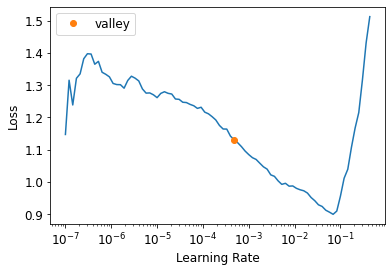

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=6, freeze_epochs=1, base_lr=0.0004)

## Train with Adam

In [ ]:
from torchvision.models.efficientnet import *


In [ ]:
#Resnet 50 / 5 epoch add Gradient Weight
#learn = cnn_learner(dls, resnet152, metrics=[accuracy,error_rate, Precision(), Recall(), F1Score()], opt_func=Adam) #, loss_func=F.cross_entropy
learn = cnn_learner(dls, efficientnet_b7, metrics=[accuracy,error_rate, Precision(), Recall(), F1Score()], opt_func=Adam) #, loss_func=F.cross_entropy


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

SuggestedLRs(valley=0.00019054606673307717)

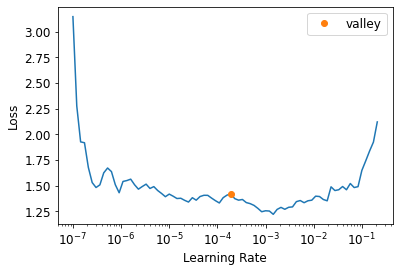

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0001)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f04e3b777a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

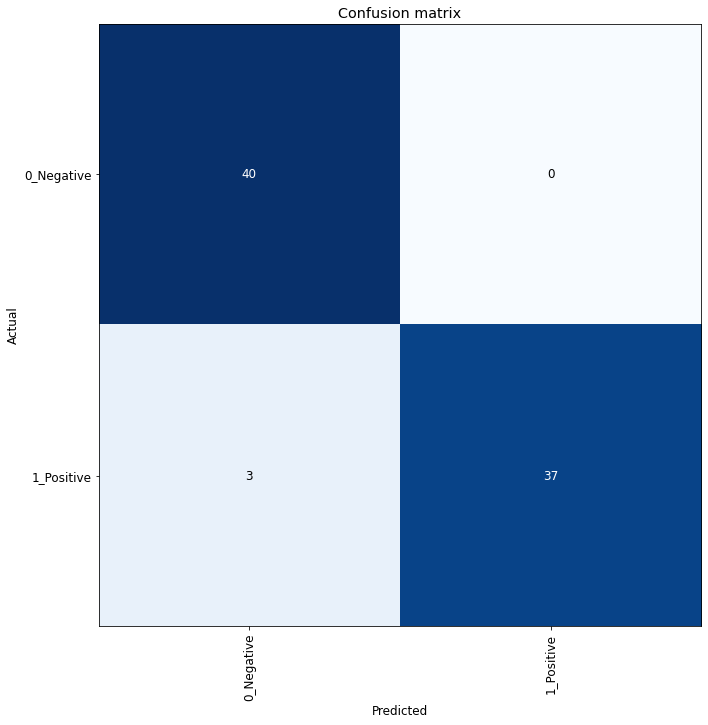

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
interp.most_confused(min_val=2)

[('1_Positive', '0_Negative', 3)]

In [ ]:
learn.show_results(shuffle=True) #true label - บน; prediction - ล่าง

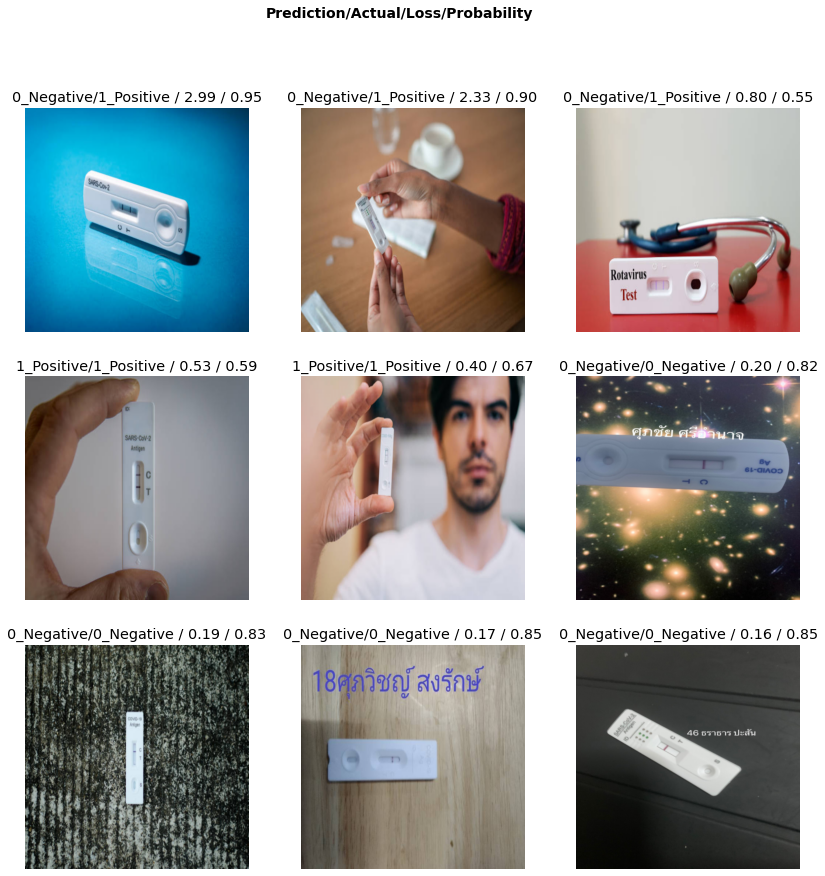

In [ ]:
interp.plot_top_losses(9, nrows=3, figsize=(14,14))

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

  0_Negative       0.93      1.00      0.96        40
  1_Positive       1.00      0.93      0.96        40

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.97      0.96      0.96        80



## Save model

In [ ]:
learn.export("/content/drive/MyDrive/AI Builder/Dataset/Weight/ATK+Idcard Efficientb_7 (96 %).pkl")

In [ ]:
learn.save('AOC (grayscale)')

Path('models/AOC (grayscale).pth')

## Resize Image (Test_Set)


In [ ]:
from PIL import Image, ImageOps
#credit : https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
def img_resize(input_path, output_path, img_size):
  desired_size = img_size
  im = Image.open(input_path)
  im = ImageOps.exif_transpose(im) # fix image rotating
  #im = im.convert('L') #Convert to gray
  old_size = im.size  # old_size[0] is in (width, height) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  # use thumbnail() or resize() method to resize the input image

  # thumbnail is a in-place operation

  # im.thumbnail(new_size, Image.ANTIALIAS)

  im = im.resize(new_size, Image.ANTIALIAS)
  # create a new image and paste the resized on it

  new_im = Image.new("RGB", (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2,
                      (desired_size-new_size[1])//2))

  #display(new_im)

  #Save resize image
  new_im.save(output_path)
  print("resize finished!!")

In [ ]:
img_resize(input_path="/content/atk_neg.PNG", output_path="/content/atk_neg.PNG", img_size=1280)

resize finished!!


In [ ]:
import os
#loop Resize image 
# put only outter path

#https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

from PIL import Image, ImageOps

def resize_img(input_img_path, img_size):
    print("running")
    count = 1
    file_path = []
    path = ""
    for root, dirs, files in os.walk(input_img_path):
        for file in files:
            if (file.lower().endswith(".jpg") or file.lower().endswith(".jpeg") or file.lower().endswith(".png")):
                desired_size = img_size
                #input img path
                im_pth = root + "/" + file

                im = Image.open(im_pth)
                im = ImageOps.exif_transpose(im) # fix image rotating
                #im = im.convert('L') #Convert to gray
                old_size = im.size  # old_size[0] is in (width, height) format

                ratio = float(desired_size)/max(old_size)
                new_size = tuple([int(x*ratio) for x in old_size])
                # use thumbnail() or resize() method to resize the input image

                # thumbnail is a in-place operation

                # im.thumbnail(new_size, Image.ANTIALIAS)

                im = im.resize(new_size, Image.ANTIALIAS)
                # create a new image and paste the resized on it

                new_im = Image.new("RGB", (desired_size, desired_size))
                new_im.paste(im, ((desired_size-new_size[0])//2,
                                    (desired_size-new_size[1])//2))

                #display(new_im)

                #Save resize image
                #new_im.save(output_img_path + "/" + file)
                new_im.save(root + "/" + file)
                count += 1
                #print(f"Processing ... img {count-1}")
    print("Resized img completed!!")
  


In [ ]:
resize_img(input_img_path="/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST 2 (Resized)",
           img_size=512)

running


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


TypeError: ignored


##**Rename Image file (Test_Set)**

In [ ]:
#single rename image
filename_type = [".jpg",".png",".jpeg"]

def change_name(file_name, change_keyword):
  name = file_name
  file_type = ""
  file_name = ""
  new_file = ""

  if name[-5] == ".":
    file_type = name[-5:]
    file_name = name[:-5]
  elif name[-4] == ".":
    file_type = name[-4:]
    file_name = name[:-4]

  new_file = file_name + "_" + change_keyword + file_type
  return new_file

change_name("/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test_resize/0_Negative", "neg")


'_neg'

In [ ]:
#loop rename image add tag (pos / neg) 
import os

def add_label_tag(folder_path, label_tag): # imgname + _(label_tag) + img_type
  count = 1
  for filename in os.listdir(folder_path):
    img_file_path = folder_path + "/" + filename
    name = img_file_path

    file_type = ""
    file_name = ""
    new_file = ""

    if name[-5] == ".":
      file_type = name[-5:]
      file_name = name[:-5]
    elif name[-4] == ".":
      file_type = name[-4:]
      file_name = name[:-4]

    new_tag_file = file_name + "_" + "(" + label_tag + ")" + file_type
    os.rename(f"{img_file_path}", f"{new_tag_file}")
    print(f"Processing.. img {count-1}")
    count+=1
  print("-----------------------------------------------------------------------------")
  print(f"Add Tag {label_tag} done! ; {count-1} img")
  

add_label_tag("/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test/1_Positive", "Pos")


Processing.. img 0
Processing.. img 1
Processing.. img 2
Processing.. img 3
Processing.. img 4
Processing.. img 5
Processing.. img 6
Processing.. img 7
Processing.. img 8
Processing.. img 9
Processing.. img 10
Processing.. img 11
Processing.. img 12
Processing.. img 13
Processing.. img 14
Processing.. img 15
Processing.. img 16
Processing.. img 17
Processing.. img 18
Processing.. img 19
Processing.. img 20
Processing.. img 21
Processing.. img 22
Processing.. img 23
Processing.. img 24
Processing.. img 25
Processing.. img 26
Processing.. img 27
Processing.. img 28
Processing.. img 29
Processing.. img 30
Processing.. img 31
Processing.. img 32
Processing.. img 33
Processing.. img 34
Processing.. img 35
Processing.. img 36
Processing.. img 37
Processing.. img 38
Processing.. img 39
-----------------------------------------------------------------------------
Add Tag Pos done! ; 40 img


In [ ]:
#Check tag name
for filename in os.listdir('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test_resize/1_Positive'):
    print(filename)

## Load Model



In [ ]:
from fastbook import *
from fastai.vision import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score



In [ ]:
learn_inf = load_learner('/content/drive/MyDrive/AI_Builder/Dataset/Weight/ATK+Idcard Efficientb_7 (96 %).pkl')
model = learn_inf.model.eval()

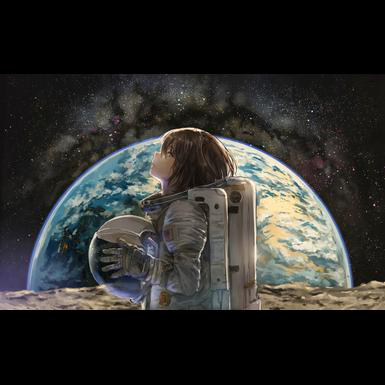

In [ ]:
im_path = '/content/anime.jpg'
im = load_image(im_path)#.resize((512, 512))
#im = im.convert('L') #Convert to gray
#im.save(im_path)
im

In [ ]:
import time
t1 = time.perf_counter()

pred = learn_inf.predict(im_path)
cls = int(pred[1]) # 0 = Negative, 1 = Positive
print(pred, cls)

t2 = time.perf_counter()
print('time taken to run: {:.2f} sec'.format(t2-t1))

('0_Negative', TensorBase(0), TensorBase([0.8150, 0.1850])) 0
time taken to run: 2.49 sec


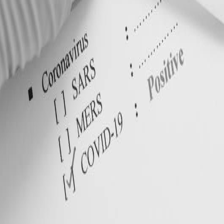

In [ ]:
im_path = '/content/test(grayPNG).'
im = load_image(im_path).resize((224, 224))
im

In [ ]:
pred = learn_inf.predict(im_path)
cls = int(pred[1]) # 0 = Negative, 1 = Positive
pred, cls

(('0_Negative', TensorBase(0), TensorBase([0.8079, 0.1921])), 0)

###  Test _Set Classification


In [ ]:
#Get Single classification detail
def get_test_detail(img_url):
  predict = learn_inf.predict(img_url)
  predict_val = predict[0]
  Positive = predict[2][1]
  Negative = predict[2][0]
  predict_per = ""
  if (predict_val == "1_Positive"):
    predict_per = Positive
  else:
    predict_per = Negative
  
  print(f"{predict_val[2:]} ; {predict_per*100} %")
  print(float(predict_per*100))

get_test_detail("/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test/0_Negative/603.img_(Neg).jpg")



Negative ; 99.99998474121094 %
99.99998474121094


In [ ]:
import os.path
from pathlib import Path
import pandas as pd

# get classificationr result
# use test --> Negative, Positive as Parent folder
def get_classification_result(img_path, save_path, pos_folder, neg_folder, save_name):
  print("running..")
  Data = {'Image_name' : [],
            'Actual label' : [],
            'Predict label' : [],
            'Accuracy' : [],
            'Result' : []}    
  predict_label = "None"
  actual_label = "None"
  result = 0



  all_folder_name = []
  neg = 0
  pos = 0
  label_folder = {"Negative" : "None", "Positive" : "None"}

  count = 1
  neg_count = 0
  pos_count = 0
  class_neg_count = 0
  class_pos_count = 0
  loss = 0
  accuracy = 0

  for filename in os.listdir(img_path):
    if filename == ".ipynb_checkpoints":
      pass
    else:
      all_folder_name.append(filename)


  for folder in all_folder_name:
    if neg_folder in folder:
      label_folder["Negative"] = folder
    elif pos_folder in folder:
      label_folder["Positive"] = folder

  if "None" in label_folder.values():
    print("Error not found label folder !")
  else:
    
    for label_name in label_folder.values():
      for filename in os.listdir(f'{img_path}/{label_name}'):
        img_url = img_path + "/" + label_name + "/" + filename

        predict = learn_inf.predict(img_url)
        predict_val = predict[0]
        Positive = predict[2][1]
        Negative = predict[2][0]
        predict_per = ""
        if (predict_val == "1_Positive"):
          predict_per = Positive
        else:
          predict_per = Negative
        
        # See detail...
        '''
        print(f"{count}. name = {img_url}")
        print(f"{count}. result = {predict_val[2:]} with {predict_per*100} %")
        print("-------------------------------------------------")
        '''
        count += 1
        

        #classification count (neg,pos)
        if predict_val[2:] == "Positive":
          class_pos_count += 1
          predict_label = "Positive"
          
        elif predict_val[2:] == "Negative":
          class_neg_count += 1
          predict_label = "Negative"
        
        # label count (neg, pos)
        if label_folder["Negative"] == label_name:
          neg_count += 1
          actual_label = "Negative"

        else:
          pos_count += 1
          actual_label = "Positive"
        
        # sum that model is predicted corrected!
        if (actual_label == predict_label):
          result = 1
        else:
          result = 0
        
        # Save model to Dataframe
        Data['Image_name'].append(filename)
        Data['Actual label'].append(actual_label)
        Data['Predict label'].append(predict_label)
        Data['Accuracy'].append(float(predict_per*100))
        Data['Result'].append(result)

        df = pd.DataFrame(Data)
        df.index = df.index + 1 # start row at 1

        df['Accuracy'] = pd.to_numeric(df['Accuracy']) # change str to int
        df['Result'] = pd.to_numeric(df['Result']) # change str to int



        
        def accuracy_find(class_count, total_count):
          accuracy_cal = class_count / total_count
          if (accuracy_cal > 1): # กรณีที่ accuracy คิดได้เกิน 100
            accuracy_cal = 1 - (accuracy_cal - 1)
          return accuracy_cal
        
        # Loss , Accuracy Check
        if (neg_count-class_neg_count == 0) and (pos_count-class_pos_count == 0): # 100% correct
            accuracy = 1
            loss = 0
        elif (neg_count == 0) and (pos_count == 0): # no label found
            accuracy = 0
            loss = 0
        elif (neg_count == 0) and (pos_count > 0): # only have neg label
            accuracy = accuracy_find(class_pos_count, pos_count)
            loss = 1 - accuracy
        elif (neg_count > 0) and (pos_count == 0): # only have pos label
            accuracy = accuracy_find(class_neg_count, neg_count)
            loss = 1 - accuracy
        elif (neg_count > 0) and (pos_count > 0): # have pos and neg label
            accuracy_neg = accuracy_find(class_neg_count, neg_count)
            accuracy_pos = accuracy_find(class_pos_count, pos_count)
            accuracy = (accuracy_neg+accuracy_pos) / 2
            loss = 1 - accuracy
      

        '''
        if (len(save_text_path) > 0):
          f = open(save_text_path, "a" )
          f.write((f"{count}. name = {filename}") + "\n" + (f"{count}. result = {predict_val[2:]} with {predict_per*100} %") + "\n" + "-------------------------------------------------" + "\n")
          f.close()
        '''

  
  print("--------------------- Conclude -----------------------")
  print(f"from : {img_path}/{label_name}")
  print(f"Label :          Total Negative = {neg_count} , Total Positive {pos_count}")
  print(f"Classification : Total Negative = {class_neg_count} , Total Positive {class_pos_count}")
  print(f"Loss : {loss} , Accuracy = {accuracy}")
  print("-------------------------------------------------------")
  

  print("Process Completed!.....")
  df.to_csv(save_path + "/" + save_name + ".csv", encoding='utf-8')
  print(f".csv have saved on {save_path}/{save_name}.csv")

  '''
  if (len(save_text_path) > 0):
    f = open(save_text_path, "a" )
    f.write(("--------------------- Conclude -----------------------") + "\n" + (f"from : {img_path}/{label_name}") + "\n"
            + (f"Label :          Total Negative = {neg_count} , Total Positive {pos_count}") + "\n" +
            (f"Classification : Total Negative = {class_neg_count} , Total Positive {class_pos_count}") + "\n" +
            (f"Loss : {loss} , Accuracy = {accuracy}") + "\n" + ("-------------------------------------------------------") + "\n")
    f.close()
    '''






In [ ]:
get_classification_result(img_path="/content/drive/MyDrive/AI_Builder/Dataset/Dataset/Test_set (resize)",
                          save_path="/content",
                          save_name = "ATK result (Effi b7)",
                          pos_folder= "1_Positive",
                          neg_folder= "0_Negative")

running..


--------------------- Conclude -----------------------
from : /content/drive/MyDrive/AI_Builder/Dataset/Dataset/Test_set (resize)/1_Positive
Label :          Total Negative = 202 , Total Positive 32
Classification : Total Negative = 202 , Total Positive 32
Loss : 0 , Accuracy = 1
-------------------------------------------------------
Process Completed!.....
.csv have saved on /content/ATK result (Effi b7).csv





## Check reasult with pandas (.csv)

In [ ]:
ATK_tabula = pd.read_csv('/content/drive/MyDrive/AI_Builder/Dataset/Data_result/ATK result (Effi b7).csv')  # โหลดข้อมูลจากไฟล์
print("OK")

OK


In [ ]:
df = ATK_tabula
df.index = df.index + 1 # start row at 1
del df['Unnamed: 0']

In [ ]:
display(df.head(10))  # ตัวอย่างข้อมูล 10 แถวแรก
display(df.tail(10))  # ตัวอย่างข้อมูล 10 แถวสุดท้าย

Image_name Actual label Predict label   Accuracy  Result
1     12.test_set(Neg).jpg     Negative      Negative  97.684448       1
2     1.test_set(Neg).jpeg     Negative      Negative  98.938225       1
3    105.test_set(Neg).jpg     Negative      Negative  99.635040       1
4        601.img_(Neg).jpg     Negative      Positive  95.187759       0
5     27.test_set(Neg).jpg     Negative      Negative  99.420387       1
6     36.test_set(Neg).jpg     Negative      Negative  99.891678       1
7    16.test_set(Neg).jpeg     Negative      Negative  93.415977       1
8   165.test_set(Neg).jpeg     Negative      Negative  98.704742       1
9   163.test_set(Neg).jpeg     Negative      Negative  98.498444       1
10     3.test_set(Neg).jpg     Negative      Negative  98.993568       1

Image_name Actual label Predict label   Accuracy  Result
236   671.img_(Positive).jpg     Positive      Positive  99.990608       1
237   669.img_(Positive).jpg     Positive      Positive  99.826256       1
238   668.img_(Positive).jpg     Positive      Positive  94.303642       1
239   664.img_(Positive).jpg     Positive      Positive  97.252296       1
240   663.img_(Positive).jpg     Positive      Positive  96.314110       1
241  660.img_(Positive).jpeg     Positive      Positive  99.940384       1
242   665.img_(Positive).jpg     Positive      Negative  68.944672       0
243   666.img_(Positive).jpg     Positive      Positive  99.801010       1
244      2.test_set(Pos).JPG     Positive      Negative  54.367744       0
245     1.test_set(Pos).jpeg     Positive      Negative  74.901550       0

### Total img

In [ ]:
df.count()

Image_name       245
Actual label     245
Predict label    245
Accuracy         245
Result           245
dtype: int64

### Correct predict

In [ ]:
correct = df.loc[df['Result'] == 1]

print(correct.count())

Image_name       239
Actual label     239
Predict label    239
Accuracy         239
Result           239
dtype: int64


In [ ]:
correct

Image_name Actual label Predict label   Accuracy  Result
1       12.test_set(Neg).jpg     Negative      Negative  97.684448       1
2       1.test_set(Neg).jpeg     Negative      Negative  98.938225       1
3      105.test_set(Neg).jpg     Negative      Negative  99.635040       1
5       27.test_set(Neg).jpg     Negative      Negative  99.420387       1
6       36.test_set(Neg).jpg     Negative      Negative  99.891678       1
..                       ...          ...           ...        ...     ...
238   668.img_(Positive).jpg     Positive      Positive  94.303642       1
239   664.img_(Positive).jpg     Positive      Positive  97.252296       1
240   663.img_(Positive).jpg     Positive      Positive  96.314110       1
241  660.img_(Positive).jpeg     Positive      Positive  99.940384       1
243   666.img_(Positive).jpg     Positive      Positive  99.801010       1

[239 rows x 5 columns]

In [ ]:
correct.loc[correct['Actual label'] == "Positive"]

Image_name Actual label Predict label   Accuracy  Result
208   662.img_(Positive).jpg     Positive      Positive  99.976128       1
209   661.img_(Positive).jpg     Positive      Positive  99.883072       1
210   658.img_(Positive).jpg     Positive      Positive  99.864372       1
211   659.img_(Positive).jpg     Positive      Positive  98.187294       1
212   657.img_(Positive).jpg     Positive      Positive  98.889336       1
213   645.img_(Positive).jpg     Positive      Positive  99.756706       1
214  656.img_(Positive).jpeg     Positive      Positive  99.428314       1
215   653.img_(Positive).jpg     Positive      Positive  99.813828       1
216   652.img_(Positive).jpg     Positive      Positive  99.327538       1
217   650.img_(Positive).jpg     Positive      Positive  99.545288       1
218  654.img_(Positive).jpeg     Positive      Positive  99.976891       1
219   649.img_(Positive).jpg     Positive      Positive  99.416939       1
220   648.img_(Positive).jpg     Positive      Positive  98.247932       1
221   647.img_(Positive).jpg     Positive      Positive  98.718277       1
222   646.img_(Positive).jpg     Positive      Positive  88.962349       1
223   644.img_(Positive).jpg     Positive      Positive  99.936752       1
224  641.img_(Positive).jpeg     Positive      Positive  99.845337       1
225   642.img_(Positive).jpg     Positive      Positive  85.156380       1
226   643.img_(Positive).jpg     Positive      Positive  99.451897       1
227  680.img_(Positive).jpeg     Positive      Positive  99.965073       1
228  679.img_(Positive).jpeg     Positive      Positive  99.483139       1
229   675.img_(Positive).jpg     Positive      Positive  99.560295       1
230   678.img_(Positive).jpg     Positive      Positive  97.787697       1
231   676.img_(Positive).jpg     Positive      Positive  98.744438       1
232   674.img_(Positive).jpg     Positive      Positive  99.863068       1
233   677.img_(Positive).jpg     Positive      Positive  97.971001       1
234   673.img_(Positive).jpg     Positive      Positive  99.418701       1
235   672.img_(Positive).jpg     Positive      Positive  99.526535       1
236   671.img_(Positive).jpg     Positive      Positive  99.990608       1
237   669.img_(Positive).jpg     Positive      Positive  99.826256       1
238   668.img_(Positive).jpg     Positive      Positive  94.303642       1
239   664.img_(Positive).jpg     Positive      Positive  97.252296       1
240   663.img_(Positive).jpg     Positive      Positive  96.314110       1
241  660.img_(Positive).jpeg     Positive      Positive  99.940384       1
243   666.img_(Positive).jpg     Positive      Positive  99.801010       1

 Correct Accuracy < 95 %

In [ ]:
df2 = correct
correct_95 = df2.loc[df2['Accuracy'] <= 95]
correct_95

Image_name Actual label Predict label   Accuracy  Result
7     16.test_set(Neg).jpeg     Negative      Negative  93.415977       1
15   164.test_set(Neg).jpeg     Negative      Negative  86.557030       1
26    100.test_set(Neg).jpg     Negative      Negative  93.129036       1
36   102.test_set(Neg).jpeg     Negative      Negative  86.557030       1
51        613.img_(Neg).jpg     Negative      Negative  78.835014       1
59        604.img_(Neg).jpg     Negative      Negative  92.976723       1
60        612.img_(Neg).jpg     Negative      Negative  94.615913       1
65     37.test_set(Neg).jpg     Negative      Negative  75.845284       1
67    49.test_set(Neg).jpeg     Negative      Negative  93.415977       1
68     43.test_set(Neg).jpg     Negative      Negative  92.255524       1
72        602.img_(Neg).jpg     Negative      Negative  84.774361       1
82      9.test_set(Neg).jpg     Negative      Negative  92.255524       1
98   131.test_set(Neg).jpeg     Negative      Negative  88.057930       1
109   143.test_set(Neg).jpg     Negative      Negative  92.218674       1
114   150.test_set(Neg).jpg     Negative      Negative  70.051643       1
129   160.test_set(Neg).jpg     Negative      Negative  93.129036       1
162    59.test_set(Neg).jpg     Negative      Negative  87.862549       1
222  646.img_(Positive).jpg     Positive      Positive  88.962349       1
225  642.img_(Positive).jpg     Positive      Positive  85.156380       1
238  668.img_(Positive).jpg     Positive      Positive  94.303642       1

### Wrong predict

In [ ]:
wrong = df.loc[df['Result'] == 0]

print(wrong.count())

Image_name       6
Actual label     6
Predict label    6
Accuracy         6
Result           6
dtype: int64


In [ ]:
wrong['Image_name'].count()

6

In [ ]:
wrong

Image_name Actual label Predict label   Accuracy  Result
4         601.img_(Neg).jpg     Negative      Positive  95.187759       0
117   148.test_set(Neg).jpg     Negative      Positive  78.601311       0
205    93.test_set(Neg).jpg     Negative      Positive  78.601311       0
242  665.img_(Positive).jpg     Positive      Negative  68.944672       0
244     2.test_set(Pos).JPG     Positive      Negative  54.367744       0
245    1.test_set(Pos).jpeg     Positive      Negative  74.901550       0

Wrong accuracy < 95

In [ ]:
df3 = wrong
wrong_95 = df3.loc[df3['Accuracy'] <= 95]
wrong_95

Image_name Actual label Predict label   Accuracy  Result
117   148.test_set(Neg).jpg     Negative      Positive  78.601311       0
205    93.test_set(Neg).jpg     Negative      Positive  78.601311       0
242  665.img_(Positive).jpg     Positive      Negative  68.944672       0
244     2.test_set(Pos).JPG     Positive      Negative  54.367744       0
245    1.test_set(Pos).jpeg     Positive      Negative  74.901550       0

### Not sure (Re take img again for sure!)

In [ ]:
re_take = df.loc[df['Accuracy'] < 80]
re_take

Image_name Actual label Predict label   Accuracy  Result
51        613.img_(Neg).jpg     Negative      Negative  78.835014       1
65     37.test_set(Neg).jpg     Negative      Negative  75.845284       1
114   150.test_set(Neg).jpg     Negative      Negative  70.051643       1
117   148.test_set(Neg).jpg     Negative      Positive  78.601311       0
205    93.test_set(Neg).jpg     Negative      Positive  78.601311       0
242  665.img_(Positive).jpg     Positive      Negative  68.944672       0
244     2.test_set(Pos).JPG     Positive      Negative  54.367744       0
245    1.test_set(Pos).jpeg     Positive      Negative  74.901550       0

In [ ]:
re_take.count()

Image_name       8
Actual label     8
Predict label    8
Accuracy         8
Result           8
dtype: int64

### Summary

In [ ]:
print(f"Total image =  {df['Image_name'].count()}")
print(f"Total loss =  {wrong['Image_name'].count()}")
print(f"Pass = {df['Image_name'].count() - wrong['Image_name'].count()} ; Loss = {wrong['Image_name'].count()}")
accuracy = ((df['Image_name'].count() - wrong['Image_name'].count()) * 100) / df['Image_name'].count()
print(f"accuracy = {accuracy} % ; loss = {100 - accuracy} %")

Total image =  245
Total loss =  6
Pass = 239 ; Loss = 6
accuracy = 97.55102040816327 % ; loss = 2.448979591836732 %


### Download Error img file to check

In [ ]:
import shutil
import os

def download_error_atkimg(all_img_path, save_error_path, label_folder):
  loss_count = df.loc[df['Result'] == 0]['Image_name'].count()
  file_name = df.loc[df['Result'] == 0]['Image_name'].values



  dst_dir = save_error_path
  copy_count = 0
    


  for folder in label_folder:
    os.chdir(all_img_path + "/" + folder)
    for name in file_name:
      for f in os.listdir():
        if name == f:
          shutil.copy(f, dst_dir)
          copy_count += 1

  if (loss_count == copy_count):
    print("Copy loss img complete on {}".format(dst_dir))

In [ ]:
download_error_atkimg(all_img_path="/content/drive/MyDrive/AI Builder/Dataset/Dataset/Full_Testset",
                   save_error_path="/content/Error_img",
                   label_folder=['0_Negative', '1_Positive'])

Copy loss img complete on /content/Error_img


In [ ]:
!zip -r /content/Error_img.zip /content/Error_img

  adding: content/Error_img/ (stored 0%)
  adding: content/Error_img/665.img_(Positive).jpg (deflated 6%)
  adding: content/Error_img/2.test_set(Pos).JPG (deflated 0%)
  adding: content/Error_img/601.img_(Neg).jpg (deflated 3%)
  adding: content/Error_img/602.img_(Neg).jpg (deflated 4%)
  adding: content/Error_img/650.img_(Positive).jpg (deflated 10%)
  adding: content/Error_img/614.img_(Neg).jpg (deflated 1%)
  adding: content/Error_img/667.img_(Positive).jpg (deflated 18%)
  adding: content/Error_img/1.test_set(Pos).jpeg (deflated 0%)
  adding: content/Error_img/609.img_(Neg).jpg (deflated 1%)
  adding: content/Error_img/655.img_(Positive).jpg (deflated 17%)


## Cross Validation K Fold

In [ ]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

In [ ]:
train_imgs =  get_image_files('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Train')
test_imgs =  get_image_files('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test')

In [ ]:
len(train_imgs), len(test_imgs)

(1279, 80)

In [ ]:
random.shuffle(train_imgs) # shuffle train_img
random.shuffle(test_imgs)
print("Shuffle Completed!")

Shuffle Completed!


In [ ]:
dsrc = Datasets(train_imgs+test_imgs, tfms=[[PILImage.create], [parent_label, Categorize]])
train_labels = L(dsrc.items).map(dsrc.tfms[1])

In [ ]:
print(f"Label = {dsrc.n_subsets}")

Label = 2


In [ ]:
dblock2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(train_name = 'Train',valid_name='Test'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    item_tfms=Resize(224, method=ResizeMethod.Squish), # Resize image to same size using Squish
    batch_tfms=aug_transforms(size=224, flip_vert=False, pad_mode=PadMode.Reflection, max_lighting=0.2, p_lighting=0.75 )
    )
dls2 = dblock2.dataloaders('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST', bs=64 ,shuffle=True)

In [ ]:
learn = cnn_learner(dls2, resnet50, metrics=[accuracy,error_rate], opt_func=Adam, pretrained=True)


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0014454397605732083)

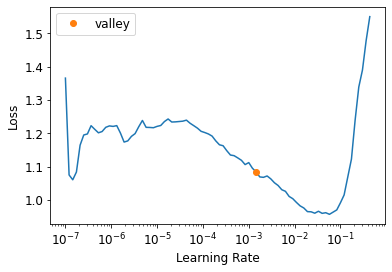

In [ ]:
learn.lr_find()

In [ ]:
val_pct = []
tst_preds = []
kf = StratifiedKFold(n_splits=10, shuffle=True)
for _, val_idx in kf.split(np.array(train_imgs+test_imgs), train_labels):
  dls2 = dblock2.dataloaders('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST', bs=64 ,shuffle=True)
  learn = cnn_learner(dls2, resnet50, metrics=[accuracy,error_rate], opt_func=Adam, pretrained=True)
  learn.fine_tune(epochs=10, freeze_epochs=1, base_lr=0.001)
  #learn.fit_one_cycle(1)
  val_pct.append(learn.validate()[1])
  a,b = learn.get_preds(ds_idx=1) # index pos, neg == 2 -- >  [0, 1]
  tst_preds.append(a)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
tst_preds_copy = tst_preds.copy()
#accuracy(tst_preds_copy[0], b)

for i in tst_preds_copy:
  print(accuracy(i, b))

TensorBase(0.9000)

In [ ]:
hat = tst_preds[0]
for pred in tst_preds[1:]:
  hat += pred

In [ ]:
hat

In [ ]:
hat /= len(tst_preds)

In [ ]:
accuracy(hat, b) 

TensorBase(0.9000)

In [ ]:
error_rate(hat, b)

TensorBase(0.1000)

# Object detection (Icevision)

## Install Icevision lib

In [ ]:
! pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
! pip install mmdet==2.17.0
! pip install icevision[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Create parser

In [ ]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir="/content/drive/MyDrive/AI_Builder/Dataset/Dataset/ATK_xml(train)/annotations", images_dir="/content/drive/MyDrive/AI_Builder/Dataset/Dataset/ATK_xml(train)/images")
train_records, valid_records = parser.parse()

  0%|          | 0/4146 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/4146 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 118-img_-Pos-_jpg.rf.00df53a741e902d3f57e5d0dca992765) - Clipping bbox ymax from 257 to image height 256 (Before: <BBox (xmin:69, ymin:6, xmax:177, ymax:257)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 118-img_-Pos-_jpg.rf.5711a0c477cdd06626cd7be924813698) - Clipping bbox ymax from 257 to image height 256 (Before: <BBox (xmin:69, ymin:6, xmax:177, ymax:257)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 118-img_-Pos-_jpg.rf.aabfb7eceb066516b32d3bc18b061d73) - Clipping bbox ymax from 257 to image height 256 (Before: <BBox (xmin:69, ymin:6, xmax:177, ymax:257)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 178-img_-Pos-_jpg.rf.4984b46b333662f1d65cbc88202d2b3f) - Clipping bbox xmax from 257 to image width 256 (Before: <BBox (xmin:32, ymin:103, xmax:257, ymax:208)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 178-img_-Pos-_jpg.rf.be9a

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

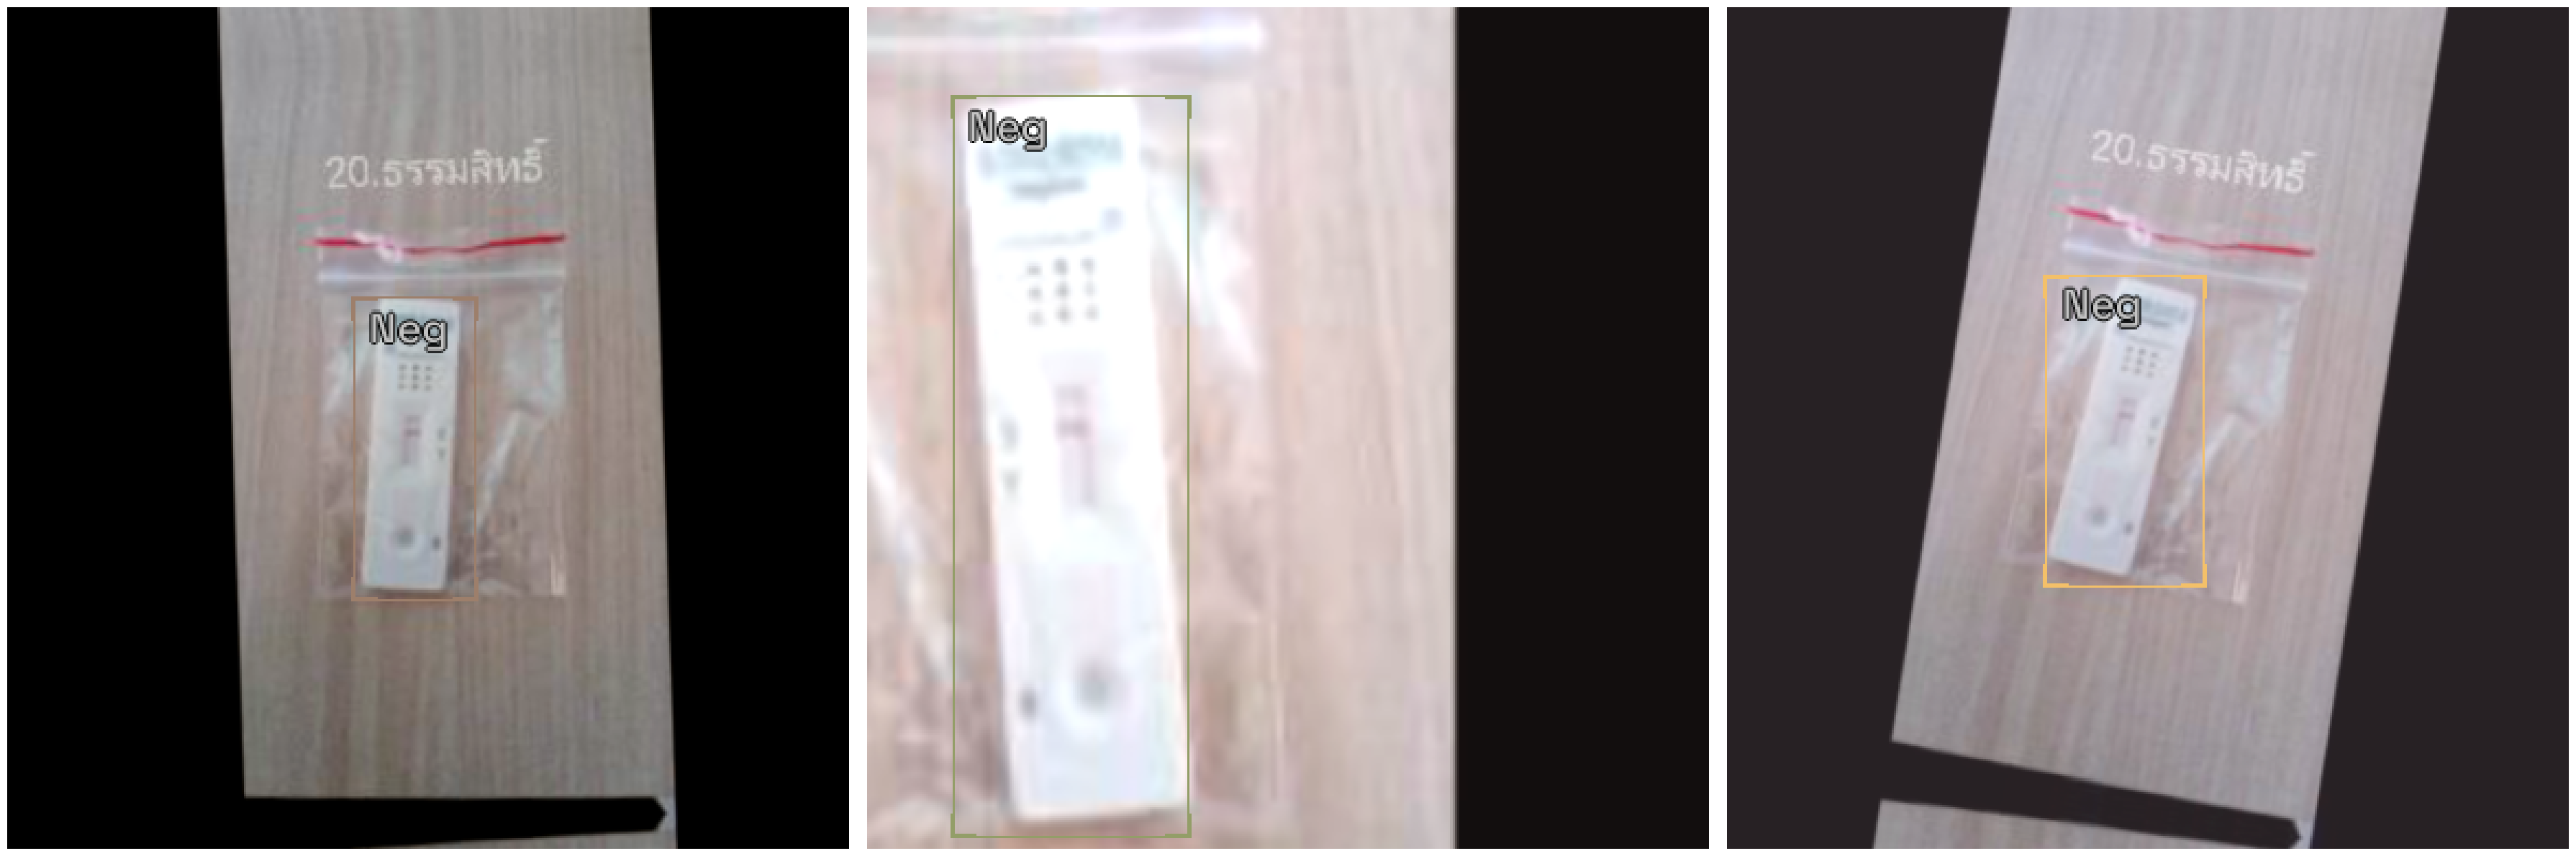

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[12] for _ in range(3)]
show_samples(samples, ncols=3)

## Config backbone

In [ ]:
# Just change the value of selection to try another model

selection = 14

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 2:
  model_type = models.mmdet.faster_rcnn
  backbone = model_type.backbones.resnet101_fpn_2x
  # extra_args['cfg_options'] = { 
  #   'model.roi_head.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.roi_head.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

if selection == 3:
  model_type = models.mmdet.ssd
  backbone = model_type.backbones.ssd300

if selection == 4:
  model_type = models.mmdet.yolox
  backbone = model_type.backbones.yolox_s_8x8

if selection == 5:
  model_type = models.mmdet.yolof
  backbone = model_type.backbones.yolof_r50_c5_8x8_1x_coco

if selection == 6:
  model_type = models.mmdet.detr
  backbone = model_type.backbones.r50_8x2_150e_coco

if selection == 7:
  model_type = models.mmdet.deformable_detr
  backbone = model_type.backbones.twostage_refine_r50_16x2_50e_coco

if selection == 8:
  model_type = models.mmdet.fsaf
  backbone = model_type.backbones.x101_64x4d_fpn_1x_coco

if selection == 9:
  model_type = models.mmdet.sabl
  backbone = model_type.backbones.r101_fpn_gn_2x_ms_640_800_coco

if selection == 10:
  model_type = models.mmdet.centripetalnet
  backbone = model_type.backbones.hourglass104_mstest_16x6_210e_coco

elif selection == 11:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn #resnet50_fpn

elif selection == 12:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 13:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 14:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_d2
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ross.efficientdet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/ross/efficientdet/__init__.py'>,
 {'img_size': 384})

In [ ]:
backbone.__dict__

{'model_name': 'tf_efficientdet_d2', 'pretrained': True}

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox), SimpleConfusionMatrix(print_summary=True)]

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(valley=0.0012022644514217973)

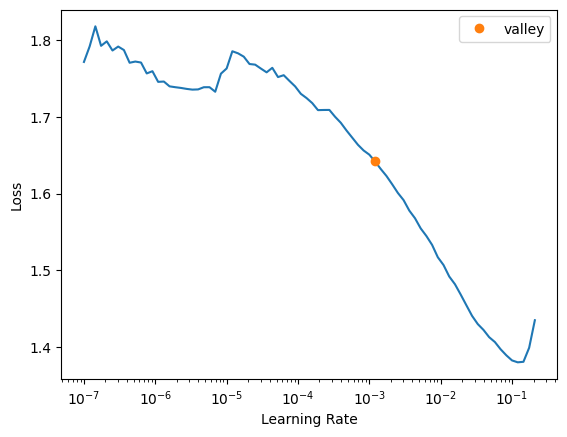

In [ ]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [ ]:
learn.fine_tune(2, 10e-3, freeze_epochs=1)

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


In [ ]:
#Plot confusion matrix
learn.metrics[1].metric.plot()

## Save model


In [ ]:
from icevision.models import *

In [ ]:
m = ClassMap(['Neg', 'Pos'])
m.get_classes()

['background', 'Neg', 'Pos']

In [ ]:
# เซฟโมเดลด้วยคำสั่ง `save_icevision_checkpoint`
checkpoint_path = "ATK_result1.pth"
save_icevision_checkpoint(
    model, 
    model_name='ross.efficientdet', 
    backbone_name='tf_lite0',
    classes=m.get_classes(),
    img_size=512,
    filename=checkpoint_path,
    meta={"icevision_version": "0.12.0"}
)

## Load model


### install lib

In [ ]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


In [ ]:
from PIL import Image, ImageOps

### upload weight model .pkl

In [ ]:
# checkpoint_path = 'checkpoints/fridge-retinanet-save-checkpoint-full.pth'

checkpoint_path = '/content/drive/MyDrive/AI_Builder/Save_result/ATK_result4_97.4.pth'

In [ ]:
from icevision.models import *

# The model is automatically recreated in the evaluation mode. To unset that mode, you only need to pass `eval_mode=Fales`)
checkpoint_and_model = model_from_checkpoint(checkpoint_path, 
    model_name='ross.efficientdet', 
    backbone_name='tf_d2',
    img_size=384, 
    is_coco=False)

load checkpoint from local path: /content/drive/MyDrive/AI_Builder/Save_result/ATK_result4_97.4.pth


06/12/2022 14:54:10 - INFO - timm.models.helpers -   Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_aa-60c94f97.pth)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_aa-60c94f97.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_aa-60c94f97.pth


In [ ]:
# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.ross.efficientdet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/ross/efficientdet/__init__.py'>,
 <ClassMap: {'background': 0, 'Neg': 1, 'Pos': 2}>,
 384)

In [ ]:
# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]

# Check device
device=next(model.parameters()).device
device

device(type='cpu')

In [ ]:
# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

### obj detection test

In [ ]:
img = PIL.Image.open('/content/size_test.jpeg')
img = ImageOps.exif_transpose(img)
width, height = img.size
pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.7)
print(width, height)

1280 1280


/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


In [ ]:
import time
t1 = time.perf_counter()

try:  
  labels, acc = pred_dict['detection']['labels'][0], pred_dict['detection']['scores'][0]
  print(labels, acc)
except IndexError:
    print("Not found Antigen test kit please take image again!")
except ValueError:# if image size to small resize it!
    print(f"Image size  not support please resize it (divide by 128)")

t2 = time.perf_counter()
print('time taken to run: {:.2f} sec'.format(t2-t1))





Pos 0.99979776
time taken to run: 0.00 sec


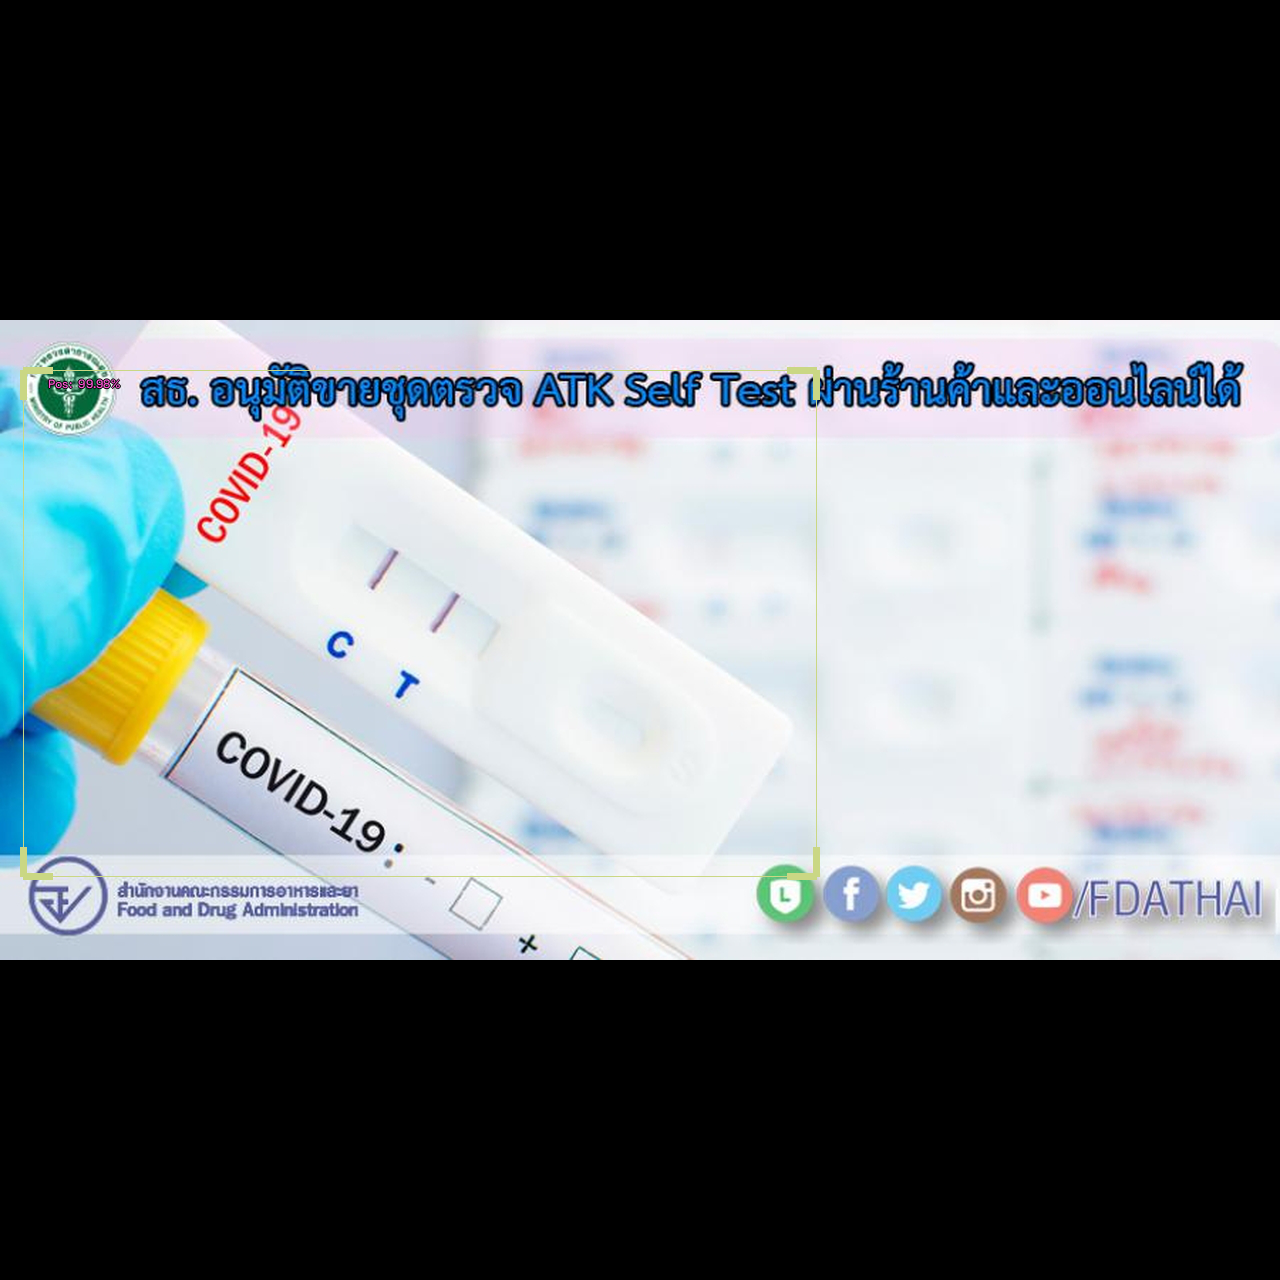

In [ ]:
pred_dict['img']

## Check result with pandas (.csv)

In [ ]:
import os.path
from pathlib import Path
import pandas as pd

# get classificationr result
# use test --> Negative, Positive as Parent folder
def get_classification_result(img_path, save_path, pos_folder, neg_folder, save_name):
  print("running..")
  Data = {'Image_name' : [],
            'Actual label' : [],
            'Predict label' : [],
            'Accuracy' : [],
            'Result' : []} 
  
  Label_name = ""

  label_status = [img_path + "/" + pos_folder, img_path + "/" + neg_folder]
  for each_label in label_status:
    if pos_folder in each_label :
      Label_name = "Pos" # Label_pos name
    else:
      Label_name = "Neg" #Label_neg name
    for filename in os.listdir(each_label):
      img = PIL.Image.open(each_label + "/" + filename)
      width, height = img.size

      df = pd.DataFrame(Data)
      df.index = df.index + 1 # start row at 1

      Data['Image_name'].append(filename) # Add image name
      Data['Actual label'].append(Label_name) # add true labels

      try:
        pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
        labels, acc = pred_dict['detection']['labels'][0], pred_dict['detection']['scores'][0]
        #print(f"pass on {filename} : {labels}, {acc} ; {img.size}")

        Data['Accuracy'].append(float(acc)) #append accuracy

        Data['Predict label'].append(labels) # add predict labels val

        if labels == Label_name:
          Data['Result'].append(1) # Correct predict
        else:
          Data['Result'].append(0) # Wrong predict
          
        
      except IndexError:
        #print(f"Not found labels! on {filename} ; {img.size}") 
        #print(path + "/" + filename)
        Data['Accuracy'].append(float(0)) #append accuracy
        Data['Predict label'].append('None')
        Data['Result'].append(0)

    
      df['Accuracy'] = pd.to_numeric(df['Accuracy']) # change str to int
      df['Result'] = pd.to_numeric(df['Result']) # change str to int    

      #print(df)
      
  print("Process Completed!.....")
  df.to_csv(save_path + "/" + save_name + ".csv", encoding='utf-8')
  
  print(f".csv have saved on {save_path}/{save_name}.csv")



In [ ]:
get_classification_result(img_path = '/content/drive/MyDrive/AI_Builder/Dataset/Dataset/Test_set (resize)', save_path = '/content/', 
                          pos_folder = '1_Positive', neg_folder = '0_Negative', 
                          save_name = 'Efficientdet_4_97.5') # save_name not need to add ".csv" in 

running..


/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Process Completed!.....
.csv have saved on /content//Efficientdet_4_97.5.csv


### Calculate accuracy from .csv


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Efficientdet_4_97.5.csv')  # โหลดข้อมูลจากไฟล์
df.index = df.index + 1 # start row at 1
del df['Unnamed: 0']
print("OK")

OK


In [ ]:
display(df.head(10))  # ตัวอย่างข้อมูล 10 แถวแรก
display(df.tail(10))  # ตัวอย่างข้อมูล 10 แถวสุดท้าย

Image_name Actual label Predict label  Accuracy  Result
1    668.img_(Positive).jpg          Pos           Pos  0.999996       1
2    675.img_(Positive).jpg          Pos           Pos  0.999972       1
3    658.img_(Positive).jpg          Pos           Pos  1.000000       1
4   641.img_(Positive).jpeg          Pos           Pos  0.997129       1
5    665.img_(Positive).jpg          Pos           Pos  0.998485       1
6    666.img_(Positive).jpg          Pos           Pos  0.999833       1
7    676.img_(Positive).jpg          Pos           Pos  0.999990       1
8    650.img_(Positive).jpg          Pos           Pos  0.999999       1
9    678.img_(Positive).jpg          Pos           Pos  0.999992       1
10   648.img_(Positive).jpg          Pos           Pos  0.999947       1

Image_name Actual label Predict label  Accuracy  Result
224      617.img_(Neg).jpg          Neg           Neg  0.999952       1
225  67.test_set(Neg).jpeg          Neg          None  0.000000       0
226  152.test_set(Neg).jpg          Neg           Neg  0.998867       1
227  105.test_set(Neg).jpg          Neg           Neg  0.999859       1
228   83.test_set(Neg).jpg          Neg           Neg  0.999613       1
229   53.test_set(Neg).jpg          Neg           Neg  0.998991       1
230  157.test_set(Neg).jpg          Neg           Neg  0.998427       1
231  47.test_set(Neg).jpeg          Neg           Neg  0.999576       1
232    4.test_set(Neg).jpg          Neg           Neg  0.997545       1
233    71.img_(Neg_ST).jpg          Neg           Neg  0.995137       1

### Total Image

In [ ]:
df.count()

Image_name       233
Actual label     233
Predict label    233
Accuracy         233
Result           233
dtype: int64

### Correct predict

In [ ]:
correct = df.loc[df['Result'] == 1]

print(correct.count())

Image_name       223
Actual label     223
Predict label    223
Accuracy         223
Result           223
dtype: int64


In [ ]:
correct

Image_name Actual label Predict label  Accuracy  Result
1     668.img_(Positive).jpg          Pos           Pos  0.999996       1
2     675.img_(Positive).jpg          Pos           Pos  0.999972       1
3     658.img_(Positive).jpg          Pos           Pos  1.000000       1
4    641.img_(Positive).jpeg          Pos           Pos  0.997129       1
5     665.img_(Positive).jpg          Pos           Pos  0.998485       1
..                       ...          ...           ...       ...     ...
229     53.test_set(Neg).jpg          Neg           Neg  0.998991       1
230    157.test_set(Neg).jpg          Neg           Neg  0.998427       1
231    47.test_set(Neg).jpeg          Neg           Neg  0.999576       1
232      4.test_set(Neg).jpg          Neg           Neg  0.997545       1
233      71.img_(Neg_ST).jpg          Neg           Neg  0.995137       1

[223 rows x 5 columns]

### Wrong predict

In [ ]:
wrong = df.loc[df['Result'] == 0]
print(wrong.count())

Image_name       10
Actual label     10
Predict label    10
Accuracy         10
Result           10
dtype: int64


In [ ]:
#All wrong
wrong

Image_name Actual label Predict label  Accuracy  Result
61     21.test_set(Neg).jpg          Neg          None  0.000000       0
68   115.test_set(Neg).jpeg          Neg          None  0.000000       0
127       621.img_(Neg).jpg          Neg          None  0.000000       0
134   103.test_set(Neg).jpg          Neg           Pos  0.984910       0
152   160.test_set(Neg).jpg          Neg           Pos  0.889704       0
155   154.test_set(Neg).jpg          Neg          None  0.000000       0
161    54.test_set(Neg).jpg          Neg          None  0.000000       0
174    37.test_set(Neg).jpg          Neg           Pos  0.997288       0
214   100.test_set(Neg).jpg          Neg           Pos  0.889704       0
225   67.test_set(Neg).jpeg          Neg          None  0.000000       0

In [ ]:
# Not found labels
labels_err = wrong.loc[wrong['Predict label'] == 'None']
print(labels_err.count())

Image_name       6
Actual label     6
Predict label    6
Accuracy         6
Result           6
dtype: int64


In [ ]:
labels_err

Image_name Actual label Predict label  Accuracy  Result
61     21.test_set(Neg).jpg          Neg          None       0.0       0
68   115.test_set(Neg).jpeg          Neg          None       0.0       0
127       621.img_(Neg).jpg          Neg          None       0.0       0
155   154.test_set(Neg).jpg          Neg          None       0.0       0
161    54.test_set(Neg).jpg          Neg          None       0.0       0
225   67.test_set(Neg).jpeg          Neg          None       0.0       0

In [ ]:
just_wrong = wrong.loc[wrong['Predict label'] != 'None']
print(just_wrong.count())

Image_name       4
Actual label     4
Predict label    4
Accuracy         4
Result           4
dtype: int64


In [ ]:
just_wrong

Image_name Actual label Predict label  Accuracy  Result
134  103.test_set(Neg).jpg          Neg           Pos  0.984910       0
152  160.test_set(Neg).jpg          Neg           Pos  0.889704       0
174   37.test_set(Neg).jpg          Neg           Pos  0.997288       0
214  100.test_set(Neg).jpg          Neg           Pos  0.889704       0

### Accuracy cal

In [ ]:
print(f"Total image =  {df['Image_name'].count()}")
print(f"Total loss =  {wrong['Image_name'].count()} ( labels not found = {labels_err['Image_name'].count()}, wrong = {just_wrong['Image_name'].count()} )")
print(f"Pass = {df['Image_name'].count() - wrong['Image_name'].count()} ; Loss = {wrong['Image_name'].count()}")
accuracy = ((df['Image_name'].count() - wrong['Image_name'].count()) * 100) / df['Image_name'].count()
print(f"accuracy = {accuracy} % ; loss = {100 - accuracy} %")

Total image =  233
Total loss =  10 ( labels not found = 6, wrong = 4 )
Pass = 223 ; Loss = 10
accuracy = 95.70815450643777 % ; loss = 4.291845493562235 %


# Deploy Model (Icevison + EasyOCR)

## install lib

In [ ]:
#EasyOCR
!pip install -U Pillow
!pip install editdistance
!pip install easyocr
! pip install pythainlp

#Icevision
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
#!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
#!bash icevision_install.sh cuda11

! pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
! pip install mmdet==2.17.0
! pip install icevision[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-12 14:39:10--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2766 (2.7K) [text/plain]
Saving to: ‘icevision_install.sh.2’

icevision_install.s 100%[===================>]   2.70K  --.-KB/s    in 0s      

2022-06-12 14:39:10 (49.5 MB/s) - ‘icevision_install.sh.2’ saved [2766/2766]

In [ ]:
#import lib
from icevision.all import *
from PIL import Image
from icevision.models import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18


## Load weight model .pkl

In [ ]:
#upload checkpoint path
checkpoint_path = '/content/drive/MyDrive/AI_Builder/Save_result/ATK_result4_97.4.pth'

In [ ]:
# The model is automatically recreated in the evaluation mode. To unset that mode, you only need to pass `eval_mode=Fales`)
checkpoint_and_model = model_from_checkpoint(checkpoint_path, 
    model_name='ross.efficientdet', 
    backbone_name='tf_d2',
    img_size=384, 
    is_coco=False)

# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]

# Check device
device=next(model.parameters()).device
device

# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])


# ID_number and name, lastname Check (ESOCR)
import editdistance
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
#import pytesseract as pts
import requests
import easyocr
from pythainlp.util import isthai


def Get_Idcard_detail(file_path):
  raw_data = []
  id_num = {"id_num" : "None"}
  name = file_path
  img = Image.open(name)
  img = ImageOps.exif_transpose(img) # fix image rotating
  #img = img.convert('L') #Convert to gray
  #img.save(name)

  #pytherass
  ''' text = pts.image_to_string(img, lang='tha+eng')
  raw_data = text.split() ''' 

  #Easy OCR
  # Doing OCR. Get bounding boxes.
  reader = easyocr.Reader(['en'])#['th','en']
  bounds = reader.readtext(name)

  split_data = []
  try:
    for data in bounds:
      split_data.append(data[1])
  except:
      print("--------Oops! index out of range-------") 

  raw_data = split_data  



  def get_english(raw_list): # Cut only english var
    eng_name = []
    thai_name = []

    for name in raw_list:
      if isthai(name) == True:
        thai_name.append(name)
      else:
        eng_name.append(name)

    ''' print("\Engname")
    print(eng_name)
    print()
    print("\Thainame")
    print(thai_name) '''
    return eng_name
  
  raw_data = get_english(raw_data)


  def Clear_syntax(raw_list):

    Clean_syntax = ["","#","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

    for k in range(len(Clean_syntax)):
      while (Clean_syntax[k] in raw_list): # remove single symbol
        raw_list.remove(Clean_syntax[k])

    for l in range(len(raw_list)): 
      raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
      raw_list[l] = raw_list[l].lower() #Set all string to lowercase

    for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
      for n in range(len(Clean_syntax)):
          raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
    return raw_list
  
  raw_data = Clear_syntax(raw_data)
  

  def get_idnum(raw_list):
    id_num = {"id_num" : "None"}
    # 1. normal check 
    for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
      try:
        if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
          id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
          break 
      except:
        pass
    
    # 2. Hardcore Check
    if id_num["id_num"] == "None":
      id_count = 0
      index_first = 0
      index_end = 0
      for i in range(len(raw_list)):
        if id_count == 13:
          index_end = i-1 #ลบ 1 index เพราะ ครบ 13 รอบก่อนหน้านี้
          #print(f"index_first == {index_first} index_end == {index_end}")
          #print(f"id = {raw_list[index_first:index_end+1]}")
          id_num["id_num"] = ''.join(raw_list[index_first:index_end+1]) 
          break
        else:
          if raw_list[i].isnumeric() == True and index_first == 0:
            id_count += len(raw_list[i])
            index_first = i
          elif raw_list[i].isnumeric() == True and index_first != 0:
            id_count += len(raw_list[i])
          elif raw_list[i].isnumeric() == False:
            id_count = 0
            index_first = 0
          
    return id_num

  id_num = (get_idnum(raw_data))

      #Complete list name check
  def list_name_check(raw_list):
    sum_list = raw_list
    name_key = ['name', 'lastname']

    #1. name_key check
    if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
      pass
    else:
      for i in range(len(name_key)):
        for j in range(len(sum_list)):
          if (editdistance.eval(name_key[i], sum_list[j]) <= 2 ): 
            sum_list[j] = name_key[i]
    
    gender_key = ["mr.", "mrs.", 'master', 'miss']
    #2 gender_key check
    count = 0 # check for break
    for i in range(len(gender_key)):
      for j in range(len(sum_list)):
        if (count == 0):
          try:
            if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
              pass
            else:
              # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
              if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
              elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
          except:
            if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
            elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
        else:
          break
    
    return sum_list

  raw_data = list_name_check(raw_data)

  #get_eng_name
  def get_engname(raw_list):
    get_data = raw_list
    engname_list = []

    name_pos = [] 
    lastname_pos = []
    mr_pos = []
    mrs_pos = []

      # check keyword by name, lastname, master, mr, miss, mrs
    for j in range(len(get_data)): #get "name" , "lastname" index
      if "name" == get_data[j]:
        name_pos.append(j)
      elif "lastname" == get_data[j]:
        lastname_pos.append(j)
      elif ("mr." == get_data[j]) or ("master" == get_data[j]):
        mr_pos.append(j)
      elif ("miss" == get_data[j]) or ("mrs." == get_data[j]):
        mrs_pos.append(j)


    if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
      engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
    elif len(lastname_pos) != 0:
      engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
    elif len(mr_pos) != 0:
      engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
    elif len(mrs_pos) != 0:
      engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
    else:
      print("Can't find eng name!!") 

    return engname_list
  
  raw_data = get_engname(raw_data)

  

  
  def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate" -> "jate"
    data = raw_list
    key = ['mrs.','mr.','master','miss']
    name = "" #gen_key name
    name_pos = 0
    gen_index = 0
    gen_type = "" #male / female
    # check keyword
    for key_val in key:
        for each_text in data:
            if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
                #each_text = each_text[len(key):]
                if (each_text == "name") or (each_text == "lastname"):
                  pass
                else:
                  name = (each_text[:len(key_val)])
                  name_pos = data.index(each_text) # get_index
                  gen_index = len(key_val)
                  """ if (key_val == key[0]) or (key_val == key[1]):
                      gen_type = "male"
                  else:
                      gen_type = "female"  """
                  break
    if (name_pos != 0): 
      data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
      for empty_str in range(data.count('')): # clear "empty string"
        data.remove('')
    return data
  
  raw_data = split_genkey(raw_data)
  
  
  def clean_name_data(raw_list): # delete all single string and int string
    for k in range(len(raw_list)):
      try:
        while ((len(raw_list[k]) <= 2) or (raw_list[k].isnumeric() == True)): # remove single symbol
          raw_list.remove(raw_list[k])
      except IndexError:
        pass
    return raw_list
  
  raw_data = clean_name_data(raw_data)


  def name_sum(raw_list):
    info = {"name" : "None",
            "lastname" : "None"}
    key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
    name_pos = 0
    lastname_pos = 0
    for key_val in key: # remove gender_key in string
      if key_val in raw_list:
        raw_list.remove(key_val)
    try:
      for i in range(len(raw_list)):
        if raw_list[i] == "name":
          info["name"] = raw_list[i+1]
          name_pos = i+1
        elif raw_list[i] == "lastname":
          info["lastname"] = raw_list[i+1]
          lastname_pos = i+1
    except:
      pass
    
    # กรณี หาอย่างใดอย่าหนึ่งเจอให้ลองข้ามไปดู 1 index name, "name_val", lastname , "lastname_val"
    if (info["name"] != "None") and (info["lastname"] == "None"):
      try:
        info["lastname"] = raw_list[name_pos+2]
      except:
        pass
    elif (info["lastname"] != "None") and (info["name"] == "None"):
      try:
        info["name"] = raw_list[lastname_pos-2]
      except:
        pass
    
    # remove . on "mr." and "mrs."
    info["name"] = info["name"].replace(".","")
    info["lastname"] = info["lastname"].replace(".","")

    
    return info

  print("Process Completed!.....")
  print(id_num)
  print(name_sum(raw_data))

# Image resize
from PIL import Image, ImageOps

def img_resize(input_path, output_path, img_size):
  desired_size = img_size
  im = Image.open(input_path)
  im = ImageOps.exif_transpose(im) # fix image rotating
  #im = im.convert('L') #Convert to gray
  old_size = im.size  # old_size[0] is in (width, height) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  # use thumbnail() or resize() method to resize the input image

  # thumbnail is a in-place operation

  # im.thumbnail(new_size, Image.ANTIALIAS)

  im = im.resize(new_size, Image.ANTIALIAS)
  # create a new image and paste the resized on it

  new_im = Image.new("RGB", (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2,
                      (desired_size-new_size[1])//2))

  #display(new_im)

  #Save resize image
  new_im.save(output_path)
  
  print("resize finished!!")


def get_detection(img_path):
 
  #Get_Idcard_detail(file_path=img_path)
  img = PIL.Image.open(img_path)
  img = ImageOps.exif_transpose(img) # fix image rotating

  try:
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  except ValueError:# if image size to small resize it!
    print(f"Image size  not support resizing...")
    img_resize(img_path,img_path,1280)
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  try:
    labels, acc = pred_dict['detection']['labels'][0], pred_dict['detection']['scores'][0]
    acc = acc * 100
    if labels == "Neg":
      labels = "Negative"
    elif labels == "Pos":
      labels = "Positive"
    print(f"Result : {labels} with accuracy {round(acc, 2)} %.")
  except IndexError:
    print("Not found Antigen test kit please take image again!")
    labels = "None"
    acc = 0

def get_img_detection(img_path):
   
  #Get_Idcard_detail(file_path=img_path)
  img = PIL.Image.open(img_path)
  img = ImageOps.exif_transpose(img) # fix image rotating

  try:
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  except ValueError:# if image size to small resize it!
    print(f"Image size  not support resizing...")
    img_resize(img_path,img_path,1280)
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
  
  return pred_dict['img']




load checkpoint from local path: /content/drive/MyDrive/AI_Builder/Save_result/ATK_result4_97.4.pth


06/12/2022 14:40:39 - INFO - timm.models.helpers -   Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_aa-60c94f97.pth)


## Get detection result (ATK + OCR)

In [ ]:
def get_result(img_path):
  import time
  t1 = time.perf_counter()
  Get_Idcard_detail(file_path=img_path)
  get_detection(img_path = img_path)
  t2 = time.perf_counter()
  print('time taken to run: {:.2f} sec'.format(t2-t1))

In [ ]:
get_result(img_path="/content/drive/MyDrive/AI_Builder/Dataset/Dataset/Baseline_test/105.test_set(Neg).jpg")

Process Completed!.....
{'id_num': '1909803191900'}
{'name': 'kunanon', 'lastname': 'rungrueang'}


/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Result : Negative with accuracy 99.97 %.
time taken to run: 7.06 sec


## See bounding box img

In [ ]:
get_img_detection(img_path="/content/drive/MyDrive/AI_Builder/Dataset/Dataset/Baseline_test/105.test_set(Neg).jpg")

# Reset Cache (Cuda Out of Memory)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
! nvidia-smi

Wed May 18 09:07:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    31W /  70W |  14124MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Code Lecture

In [ ]:
import os.path
from pathlib import Path
#os.path.dirname('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test/0_Negative/601.img_(Neg).jpg')
Path('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST').parent

PosixPath('/content/drive/MyDrive/AI Builder/Dataset/Dataset')

In [ ]:
label_folder = {"Negative" : "None", "Positive" : "None"}
if "None" in label_folder.values():
  print("none")

In [ ]:
all_folder_name = []
neg = 0
pos = 0
label_folder = {"Negative" : "None", "Positive" : "None"}

for filename in os.listdir('/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test'):
  if filename == ".ipynb_checkpoints":
    pass
  else:
    all_folder_name.append(filename)


for folder in all_folder_name:
  if "0_Negative" in folder:
    label_folder["Negative"] = folder
  elif "1_Positive" in folder:
    label_folder["Positive"] = folder

if "None" in label_folder.values():
  print("Error not found label folder !")
else:


  for label_name in label_folder.values():
    for filename in os.listdir(f'/content/drive/MyDrive/AI Builder/Dataset/Dataset/Scraping+ST/Test/{label_name}'):
      if label_folder["Negative"] == label_name:
        neg += 1
      else:
        pos += 1

  print(neg, pos)
      






  
  

40 40


In [ ]:
def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate"
    data = raw_list
    key = ['mrs','mr','master','miss']
    name = "" #gen_key name
    name_pos = 0
    gen_index = 0
    gen_type = "" #male / female
    # check keyword
    for key_val in key:
        for each_text in data:
            if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
              #each_text = each_text[len(key):]
              if (each_text == "name") or (each_text == "lastname"):
                pass
              else:
                name = (each_text[:len(key_val)])
                name_pos = data.index(each_text) # get_index
                gen_index = len(key_val)
                """ if (key_val == key[0]) or (key_val == key[1]):
                    gen_type = "male"
                else:
                    gen_type = "female"  """
                break
    if (name_pos != 0): 
      data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
      for empty_str in range(data.count('')): # clear "empty string"
        data.remove('')
      data.insert(name_pos, name) # put gender_key that already split back to the list
    return data#, name, name_pos, gen_index

split_genkey(['sarscov21', 'antigen', '2051aza10i31s89181thainationalidcard', 'latjazjnga1laew71w', '1909802983756', '4', 'identificationnumber', 'id', 'h', 'dacaua8daana78', 'awaveiana', 'name', 'mrpuvanon', 'c', 'lastname', 'nillapatsakul', 'iiajuri', '5t9', '2548', 't', 'dateofbirth', '5jul2005', 'icu', '1gm', '4180', '150', 'yiogi', '104', 'iwiniajlasnzviz', '61101', '140', '140', '0q', 'iwoi251931', '19&a2563', '4na2572', '0', 's', 'haonjas', 'jwia5waq878', '49', '2020', '118611a8avis2', '4jul2029', '90980208191312', 'date&tissue', 'la1wiinatuaonjas', 'dateofexpiry', '213651', 'tqnon', '92981s76', '34', 'iuoi', 'aug'])

['sarscov21',
 'antigen',
 '2051aza10i31s89181thainationalidcard',
 'latjazjnga1laew71w',
 '1909802983756',
 '4',
 'identificationnumber',
 'id',
 'h',
 'dacaua8daana78',
 'awaveiana',
 'name',
 'mr',
 'puvanon',
 'c',
 'lastname',
 'nillapatsakul',
 'iiajuri',
 '5t9',
 '2548',
 't',
 'dateofbirth',
 '5jul2005',
 'icu',
 '1gm',
 '4180',
 '150',
 'yiogi',
 '104',
 'iwiniajlasnzviz',
 '61101',
 '140',
 '140',
 '0q',
 'iwoi251931',
 '19&a2563',
 '4na2572',
 '0',
 's',
 'haonjas',
 'jwia5waq878',
 '49',
 '2020',
 '118611a8avis2',
 '4jul2029',
 '90980208191312',
 'date&tissue',
 'la1wiinatuaonjas',
 'dateofexpiry',
 '213651',
 'tqnon',
 '92981s76',
 '34',
 'iuoi',
 'aug']

In [ ]:
def LossCalculate(img_total, error_total):
  loss = (error_total * 100) / img_total
  print(f"accuracy = {100 - loss} ")
  print(f"loss = {loss} ")

LossCalculate(25, 3)


accuracy = 88.0 
loss = 12.0 


In [ ]:
# ID Gray Box Crop (PTS)
import cv2
from pytesseract import Output
from google.colab.patches import cv2_imshow
import os
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageOps
import pytesseract as pts

def Get_check_img(file_path, new_pic_path):
  for filename in os.listdir(file_path):
    print("Status.. == " + filename)
    raw_data = []
    name = file_path + "/" + filename
    img = Image.open(name)
    img = ImageOps.exif_transpose(img) # fix image rotating
    img = img.convert('L') #Convert to gray
    img.save(name)

    def change_name(file_name, change_keyword):
      name = file_name
      file_type = ""
      file_name = ""
      new_file = ""

      if name[-5] == ".":
        file_type = name[-5:]
        file_name = name[:-5]
      elif name[-4] == ".":
        file_type = name[-4:]
        file_name = name[:-4]

      new_file = file_name + "_" + change_keyword + file_type
      return new_file

    change_name("/content/drive/Test/AI Builder/Dataset/ATK_data/IMG_4010.JPG", "crop")

    #pytherass
    text = pts.image_to_string(img, lang='tha+eng')
    raw_data = text.split()

    img = cv2.imread(name)
    height = img.shape[0]
    width = img.shape[1]

    d = pts.image_to_boxes(img, output_type=Output.DICT)
    n_boxes = len(d['char'])
    for i in range(n_boxes):
        (text,x1,y2,x2,y1) = (d['char'][i],d['left'][i],d['top'][i],d['right'][i],d['bottom'][i])
        cv2.rectangle(img, (x1,height-y1), (x2,height-y2) , (0,255,0), 2)
    #cv2_imshow(img)
    cv2.imwrite(new_pic_path + "/" + change_name(filename, "detection"), img)
    #cv2_waitKey(0) 
  print("Process Completed!.....")

Get_check_img("/content/drive/MyDrive/Dataset/IDCard", '/content/sample_data')

Status.. == mj.jpg


KeyboardInterrupt: ignored

In [ ]:
    ''' def distance_check(raw_list):
      result = raw_list

      # method 1. name, lastname check
      def list_distancecheck(result,keyword): 
        for i in range(len(result)): 
          if editdistance.eval(keyword, result[i][:len(keyword)]) <= 2 and len(result[i][len(keyword):]) <= 2:
            result[i] = keyword
            break
        return raw_list

      listkeyword_check = ["name", "lastname", "master", "miss", "mr.", "mrs."]

      for list_keyword in listkeyword_check: #loop check keyword 
        list_distancecheck(result, list_keyword)
      
      # method 2. when gender_name are same on string ex. "Mr.Tanaanan", "Mrs.somsri"
      def string_distancecheck(result,keyword): 
        sex_index = 0
        have_edit = False # เช็คว่า gender_type ถูกแก้ไขหรือยัง
        for i in range(len(result)): 
          if (editdistance.eval(keyword, result[i][:len(keyword)]) <= 2) and len(result[i][len(keyword):]) >= 4:
            sex_index = i
            result[i] = (result[i][len(keyword):]) #cut only name back to list
            have_edit = True
            result.insert(sex_index, keyword)
            break
        return result,have_edit

      stringkeyword_check = ["master", "miss", "mr.", "mrs." ]
      for str_keyword in stringkeyword_check:
        if string_distancecheck(result,str_keyword)[1] == False: # have_edit == False ยังไม่พบ keyword ที
          string_distancecheck(result,str_keyword)[0]
        else: # have_edit == True พบ keyword แล้วแก้ไขแล้วให้ทำการหยุดการทำงาน เพราะ gender_type มีแค่อันเดียวเท่านั้น
          break 
      return result

    raw_data = distance_check(raw_data) '''

In [ ]:
import editdistance


def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate"
    data = raw_list
    key = ['mrs.','mr.','master','miss']
    name = "" #gen_key name
    name_pos = 0
    gen_index = 0
    gen_type = "" #male / female
    # check keyword
    for key_val in key:
        for each_text in data:
            if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 2 and (len(each_text[:len(key_val)]) == len(key_val))):
                #each_text = each_text[len(key):]
                name = (each_text[len(key_val):])
                name_pos = data.index(each_text) # get_index
                gen_index = len(key_val)
                """ if (key_val == key[0]) or (key_val == key[1]):
                    gen_type = "male"
                else:
                    gen_type = "female"  """
                break
    data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
    return data



split_genkey(['name', 'mrnakharin', 'lastname', 'name', 'inaiun', '206'])
        


['name', 'akharin', 'lastname', 'name', 'inaiun', '206']

In [ ]:
def name_sum(raw_list):
      info = {"name" : "None",
              "lastname" : "None"}
      key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
      for key_val in key:
        if key_val in raw_list:
          raw_list.remove(key_val)
      try:
        for i in range(len(raw_list)):
          if raw_list[i] == "name":
            info["name"] = raw_list[i+1]
          elif raw_list[i] == "lastname":
            info["lastname"] = raw_list[i+1]
      except:
        pass
      return info
name_sum(['name', 'mr.','natthakrit', 'lastname','amphaichaichok', 'maiun25i.u.2547', 'dateofburth25jun.2004'])

{'lastname': 'amphaichaichok', 'name': 'natthakrit'}

In [ ]:
import editdistance
data = ['b', 'n', 'mm', 'h', 'c', '0', 'j8', 'command', 'option', 'slsle5', 'ioslazioanlav131thainationalidcard', 'note', 'lamilavin031380131', 'identificatlonnumber', 'derizuaededns181865598618128', 'name', 'mi.chalut', 'labtname', 'sinthanachal', '170', '170', '6176w1', 'wn6', '16', '13', '24985walii4', '0,517a113w9a97aa3f', '150', 'i50', 'a.ajwsn', 'a,nalvey', '9.6199131', '0', '6&a.2563', '28g.a.2571', 'u', 'juoontat', 'jui91m4qd14', '6jan.2020', "wnuu7a3'91892", '28dec.2028', 'dateofissue', 'gahwiinvnwaonin3', 'dateofexplry', '90980201080958', 'aed']
editdistance.eval('mr', 'mrs.')


2

In [ ]:
#"www.computerhope.com".startswith("www.")

# Edit distance check!
#data = ['jasuaeanoajlav9139thainationalidcard', 'avlsej1aus1n34', '1909802945731', 'ldentincationnumber', 'dociquadwaqa78', 'fwjevif4v1s221', 'nane', 'mr.thanawat', 'lastname', 'ngunorn', 'haiui', '2&.a:2548', '870', 'dateofbirth', '2mar.2005', 'f78w1', 'vn', '164', '160', '349', 'walfi4.eiinuai?', '150', '1504', '2.681013.614931', '30i.a.2564', '1', 'a.2573', 'mo', '140', 'jwajnjas', 'juiajuanu', '30mar.2021', '47064792jj352', '1', 'mar', '2030', '90100203300858', 'dateoflesue', 'innwvnjowjonjos', 'dateofexplry', 'l', '7ay']

def distance_check(raw_list):
  result = raw_list

  # method 1. name, lastname check ex. "Mr.", "Tanaanan" อยู่แยกกัน
  def list_distancecheck(result,keyword): 
    have_edit = False # เช็คว่า gender_type ถูกแก้ไขหรือยัง
    for i in range(len(result)): 
      if editdistance.eval(keyword, result[i][:len(keyword)]) <= 2 and len(result[i][len(keyword):]) <= 2:
        result[i] = keyword
        have_edit = True
        break
    return raw_list,have_edit

  listkeyword_check = ["name", "lastname"]

  for list_keyword in listkeyword_check: #loop check keyword name, lastname
    list_distancecheck(result, list_keyword)

  listgender_check = ["master", "miss", "mr.", "mrs."]

  for list_genderkeyword in listgender_check:
    if list_distancecheck(result,list_genderkeyword)[1] == True: # have_edit == True พบ keyword แล้วแก้ไขแล้วให้ทำการหยุดการทำงาน เพราะ gender_type มีแค่อันเดียวเท่านั้
      list_distancecheck(result,list_genderkeyword)[0]
      break
  
  
    if ("master" and "miss" and "mr" and "mrs") not in result: # ถ้ายังไม่เจอ gender_type อีกให้หาต่อ!!
      # method 2. when gender_name are same on string ex. "Mr.Tanaanan", "Mrs.somsri"
      def string_distancecheck(result,keyword): 
        sex_index = 0
        have_edit = False # เช็คว่า gender_type ถูกแก้ไขหรือยัง
        for i in range(len(result)): 
          if (editdistance.eval(keyword, result[i][:len(keyword)]) <= 2) and len(result[i][len(keyword):]) >= 4:
            sex_index = i
            result[i] = (result[i][len(keyword):]) #cut only name back to list
            have_edit = True
            result.insert(sex_index, keyword)
            break
        
        return result,have_edit

      #bug here!!
      stringkeyword_check = ["master", "mr.", "miss", "mrs." ]
      for str_keyword in stringkeyword_check:
        if string_distancecheck(result,str_keyword)[1] == True: # have_edit == True พบ keyword แล้วแก้ไขแล้วให้ทำการหยุดการทำงาน เพราะ gender_type มีแค่อันเดียวเท่านั้
          string_distancecheck(result,str_keyword)[0]
          break 
  return result


  
#distance_check(['name', 'mr.sirawich', 'lastname', 'maneewan', 'ljaju'])
distance_check(['name', 'nias','possawee', 'lastname', 'laparunvit', 'nias', '27w.a2547'])



['name',
 'miss',
 'miss',
 'awee',
 'lastname',
 'laparunvit',
 'lhqjuy',
 '27w.a2547']

In [ ]:
#Complete list name check
def list_name_check(raw_list):
  sum_list = raw_list
  name_key = ['name', 'lastname']

  #1. name_key check
  if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
    pass
  else:
    for i in range(len(name_key)):
      for j in range(len(sum_list)):
        if (editdistance.eval(name_key[i], sum_list[j]) <= 3 ): 
          sum_list[j] = name_key[i]
  
  gender_key = ["mr", "mrs", 'master', 'miss']
  #2 gender_key check
  count = 0 # check for break
  for i in range(len(gender_key)):
    for j in range(len(sum_list)):
      if (count == 0):
        if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
          pass
        else:
          # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
          if (gender_key[i] == "mr" or gender_key[i] == "mrs") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
            sum_list[j] = gender_key[i]
            count+=1
            #print(1)
          elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
            sum_list[j] = gender_key[i]
            count+=1
            #print(1)
      else:
        break
  
  return sum_list

list_name_check(['nane', 'mys','itsnamehere', 'lastnama', 'andlastname',  '27w.a2547'])


['name', 'mrs', 'itsnamehere', 'lastname', 'lastname', '27w.a2547']

In [ ]:
def string_distancecheck(result,keyword): 
  sex_index = 0
  count = 0 # check for break
  for i in range(len(result)): 
    if (count == 0):
      if (editdistance.eval(keyword, result[i][:len(keyword)]) <= 1) and (len(keyword) == len(result[i][:len(keyword)])):
        sex_index = i
        result[i] = (result[i][len(keyword):]) #cut only name back to list
        result.insert(sex_index, keyword)
        count+=1
    else:
      break
  return result

string_distancecheck(['nane','mritsnamehere', 'lastnama', 'andlastname',  '27w.a2547'],"mrs")

['nane', 'mrs', 'tsnamehere', 'lastnama', 'andlastname', '27w.a2547']

In [ ]:
editdistance.eval("lastnama","lastname")

1

In [ ]:
gender_key = ["mr", "mrs", 'master', 'miss']
  #2 gender_key check
  count = 0 # check for break
  for i in range(len(gender_key)):
    for j in range(len(sum_list)):
      if (count == 0):
        if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
          pass
        else:
          # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
          if (gender_key[i] == "mr" or gender_key[i] == "mrs") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
            sum_list[j] = gender_key[i]
            count+=1
            #print(1)
          elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
            sum_list[j] = gender_key[i]
            count+=1
            #print(1)
      else:
        break

In [ ]:
#check name, lastname
data = ['name', 'mastyu','possawee', 'lauuname', 'laparunvit',  '27w.a2547']
name = ['name', 'lastname']

lst = data
if ("name" in data) and ("lastname" in data): # if name and lastname in list pass it!
  pass
else:
  for i in range(len(name)):
    for j in range(len(lst)):
      if (editdistance.eval(name[i], lst[j]) <= 3 ): 
        lst[j] = name[i]

print(lst)


['name', 'mastyu', 'possawee', 'lastname', 'laparunvit', '27w.a2547']


In [ ]:
import editdistance
#gender_type check
#problem on keyword mr and mrs
data = ["mr.", "mrs.", 'master', 'miss']
lst = ['name', 'mastyu','possawee', 'lastnama', 'laparunvit',  '27w.a2547']


count = 0 # check for break
for i in range(len(data)):
  for j in range(len(lst)):
    if (count == 0):
      if (lst[i] == "name") or (lst[i] == "lastname"): # skip "name" and "lastname"
        pass
      else:
        # mr, mrs sensitive case double check with len(data) == len(keyword)
        if (data[i] == "mr" or data[i] == "mrs") and (editdistance.eval(data[i], lst[j]) <= 2 and (len(data[i]) == len(lst[j]))): 
          lst[j] = data[i]
          count+=1
          #print(1)
        elif (data[i] == "master" or data[i] == "miss") and (editdistance.eval(data[i], lst[j]) <= 3 ) and (len(data[i]) == len(lst[j])):
          lst[j] = data[i]
          count+=1
          #print(1)
    else:
      break

print(lst)
      

['name', 'master', 'possawee', 'lastnama', 'laparunvit', '27w.a2547']


In [ ]:
import editdistance
#gender_type check
#problem on keyword mr and mrs
data = ["mr.", "mrs.", 'master', 'miss']
lst = ['mrs.possawee', 'lastname', 'laparunvit',  '27w.a2547']

count = 0 # check for break
sex_index = 0 
for i in range(len(data)):
  for j in range(len(lst)):
    if (count == 0):
      # mr, mrs sensitive case double check with len(data) == len(keyword)
      if (data[i] == "mr" or data[i] == "mrs") and (editdistance.eval(data[i], lst[j][:len(data[i])]) <= 2): 
        sex_index = j
        lst[j] = lst[j][len(data[i]):]
        lst.insert(sex_index, data[i])
        count+=1
        print(1)
    else:
      break

print(lst)

ml
mls
mlss
['mlsspossawee', 'lastname', 'laparunvit', '27w.a2547']


In [ ]:
import editdistance
def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate"
  data = raw_list
  key = ['mrs','mr','master','miss']
  name = "" #gen_key name
  name_pos = 0
  gen_index = 0
  gen_type = "" #male / female
  # check keyword
  for key_val in key:
      for each_text in data:
          if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
              #each_text = each_text[len(key):]
              print(each_text[:len(key)], key_val)
              if (each_text == "name") or (each_text == "lastname"):
                pass
              else:
                name = (each_text[len(key_val):])
                name_pos = data.index(each_text) # get_index
                gen_index = len(key_val)
                """ if (key_val == key[0]) or (key_val == key[1]):
                    gen_type = "male"
                else:
                    gen_type = "female"  """
                break
  if (name_pos != 0): 
    data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
    for empty_str in range(data.count('')): # clear "empty string"
      data.remove('')
  return data

split_genkey(['mrtanaanan', 'chalearmpan'])